In [1]:

import os
import datetime
import copy

import os
os.environ["OMP_NUM_THREADS"] = '6'

import numpy as np
from numpy.random import normal as rnorm, multinomial as rmultinomial
import scipy.stats
from scipy.special import logsumexp, loggamma
from sklearn.mixture import GaussianMixture
from sklearn.metrics import r2_score, mean_squared_error, roc_auc_score
from sklearn.linear_model import LinearRegression, RidgeCV, Ridge, LogisticRegression, LogisticRegressionCV
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVR

import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm


import warnings

warnings.simplefilter(action='ignore', category=sm.tools.sm_exceptions.DomainWarning)


In [2]:
class MSLR():
    
    def __init__(self, n_components = 2, covariance_type="full", n_iter = 10):
        self.n_components = n_components
        self.n_iter = n_iter
        self.covariance_type = covariance_type 
        self.tol = 0.0
        
        self.reg_method = LinearRegression
        #self.reg_method = RidgeCV
        #self.reg_method = LinearSVR
        
        return
    
    
    def fit_predict(self, X, Y, X_test, is_multiple_sequence = False):
        
        matmul_log = lambda A, log_b: np.array([logsumexp(np.log(tmp_line) + log_b) for tmp_line in A])
        
        if is_multiple_sequence:
            list_X, list_Y = [np.array(i) for i in X], [np.array(i) for i in Y]
            list_X_test = [np.array(i) for i in X_test] if X_test is not None else None
        else:
            list_X, list_Y = [np.array(X)], [np.array(Y)]
            list_X_test = [np.array(X_test)] if X_test is not None else None
        
        marginal_X, marginal_Y = np.concatenate(list_X), np.concatenate(list_Y)
        gmm = GaussianMixture(n_components = self.n_components, covariance_type = self.covariance_type)
        gmm.fit(marginal_Y)
        
        n_seq = len(list_X)
        list_T = [len(i) for i in list_X]
        
        p_X, p = len(list_X[0][0]), len(list_Y[0][0])
        K = self.n_components
        self.n_features = p
        
        self.transmat_ = np.array([[1. / K for j in range(K)] for i in range(K)])

        self.list_loglik_ = []
        for epoch in range(self.n_iter):

            # M-step
            if epoch != 0:
                tmp_weight_mat = []
                for cur_log_forward_prob, cur_log_backward_prob in zip(list_cur_log_forward_prob, list_cur_log_backward_prob):
                    tmp_log_weight_mat = cur_log_forward_prob + cur_log_backward_prob
                    tmp_log_weight_mat -= logsumexp(tmp_log_weight_mat[-1, :])
                    tmp_weight_mat.append(np.exp(tmp_log_weight_mat))
                tmp_weight_mat = np.concatenate(tmp_weight_mat)
            else:
                tmp_weight_mat = gmm.predict_proba(marginal_Y)
                
            list_lr_cov = []
            for ii in range(K):
                tmp_weight = tmp_weight_mat[:, ii]
                tmp_lr = self.reg_method()
                tmp_lr.fit(marginal_X, marginal_Y, sample_weight = tmp_weight)
                tmp_resid = marginal_Y - tmp_lr.predict(marginal_X)
                if self.covariance_type == "full":
                    tmp_cov_sum = np.zeros(shape = (p, p))
                    for jj in range(len(marginal_X)):
                        tmp_x = tmp_resid[jj, :]
                        tmp_cov_sum += np.outer(tmp_x, tmp_x) * tmp_weight[jj]
                    tmp_cov = tmp_cov_sum / np.sum(tmp_weight) 
                elif self.covariance_type == "diag":
                    tmp_cov = np.array([max(np.sum(tmp_weight * (tmp_resid[:, j] ** 2)) / np.sum(tmp_weight), 1e-12) for j in range(p)])
                list_lr_cov.append((tmp_lr, tmp_cov))
            self.list_lr_cov = list_lr_cov
            
            list_cur_mat_log_b = self._calc_emission_mat(list_X, list_Y)
            list_list_log_emission = [[np.copy(list_cur_mat_log_b[index_X][i, :]) for i in range(T)] for index_X, T in enumerate(list_T)]
                        
            if epoch != 0:
                cur_log_initprob = [list_cur_log_forward_prob[i][0] + list_cur_log_backward_prob[i][0] for i in range(n_seq)]
            else:
                cur_log_initprob = [[np.log(i) if i != 0 else -100 for i in line] for line in gmm.predict_proba([Y[0] for Y in list_Y])]
            
            cur_log_initprob = np.sum(cur_log_initprob, axis = 0)
            cur_log_initprob -= logsumexp(cur_log_initprob)
            self.startprob_ = np.exp(cur_log_initprob)
            self.log_startprob_ = cur_log_initprob

            # E-step      
            list_cur_log_forward_prob = [[] for i in range(n_seq)]
            for index_X, X in enumerate(list_X):
                for tt in range(len(X)):
                    if tt == 0:
                        tmp_log_prob = cur_log_initprob + list_cur_mat_log_b[index_X][0, :]
                    else:
                        tmp_log_prob = matmul_log(np.transpose(self.transmat_), list_cur_log_forward_prob[index_X][-1]) + list_cur_mat_log_b[index_X][tt, :]
                    list_cur_log_forward_prob[index_X].append(tmp_log_prob)
            list_cur_log_forward_prob = [np.array(i) for i in list_cur_log_forward_prob]
            
            list_cur_log_backward_prob = [[0 for i in range(T)] for T in list_T]
            for index_X, (X, T) in enumerate(zip(list_X, list_T)):
                for tt in range(T - 1, -1, -1):
                    if tt == T - 1:
                        tmp_log_prob = np.array([np.log(1.) for i in range(K)])
                    else:
                        tmp_log_prob = []
                        for ii in range(K):
                            tmp_log_prob.append(logsumexp([np.log(self.transmat_[ii, j]) + list_cur_mat_log_b[index_X][tt + 1, j] + list_cur_log_backward_prob[index_X][tt + 1][j] for j in range(K)]))
                        tmp_log_prob = np.array(tmp_log_prob)
                    list_cur_log_backward_prob[index_X][tt] = tmp_log_prob
            list_cur_log_backward_prob = [np.array(i) for i in list_cur_log_backward_prob]
            
            list_tmp_array2d_log_gamma = [i + j for (i, j) in zip(list_cur_log_forward_prob, list_cur_log_backward_prob)]
            list_tmp_array1d_log_gamma_sum = [[logsumexp(i[t, :]) for t in range(len(i))] for i in list_tmp_array2d_log_gamma]
            
            list_tmp_array3d_log_epsilon = [np.zeros(shape = (T - 1, K, K)) for T in list_T]
            for index_X, (X, T) in enumerate(zip(list_X, list_T)):
                for tt in range(T - 1):
                    for ii in range(K):
                        for jj in range(K):
                            list_tmp_array3d_log_epsilon[index_X][tt, ii, jj] = list_cur_log_forward_prob[index_X][tt, ii] + np.log(self.transmat_[ii, jj]) + \
                                    list_cur_log_backward_prob[index_X][tt + 1, jj] + list_cur_mat_log_b[index_X][tt + 1, jj] - list_tmp_array1d_log_gamma_sum[index_X][tt]            
        
            self.transmat_ = self._calc_transmat(list_tmp_array3d_log_epsilon)
            
            loglik = np.sum([logsumexp(i[-1]) for i in list_cur_log_forward_prob])
            self.list_loglik_.append(loglik)
            
            if (len(self.list_loglik_) >= 2) and (abs(self.list_loglik_[-1] - self.list_loglik_[-2]) < self.tol):
                break
            
            #print("epoch % s, loglik = % s" % (epoch, loglik))
            #print(cur_list_mvn_mean_cov)
            #print(cur_transmat)
        
        self.list_last_posterior = [i[-1] + j[-1] for (i, j) in zip(list_cur_log_backward_prob, list_cur_log_forward_prob)]
        for ii in range(n_seq):
            tmp = self.list_last_posterior[ii]
            tmp -= np.max(tmp)
            tmp = np.exp(tmp)
            tmp /= np.sum(tmp)
            self.list_last_posterior[ii] = tmp
        
        if list_X_test is None:
            pred = None
        else:
            pred = []
            for ii in range(n_seq):
                tmp_pred_prob = self.list_last_posterior[ii] @ self.transmat_
                tmp_pred = 0
                for tmp_k in range(K):
                    tmp_pred += list_lr_cov[tmp_k][0].predict([list_X_test[ii]])[0] * tmp_pred_prob[tmp_k]
                pred.append(tmp_pred)

            if not is_multiple_sequence:
                pred = pred[0]
        
        return pred
    
    
    def fit(self, X, Y, is_multiple_sequence = False):
        self.fit_predict(X = X, Y = Y, X_test = None, is_multiple_sequence = is_multiple_sequence)
        return
    
    
    def _calc_transmat(self, list_tmp_array3d_log_epsilon):
        K = self.n_components
        cur_transmat = np.zeros((K, K)) 
        for ii in range(K):
            tmp_list_log_prob = []
            for jj in range(K):
                tmp_log_prob = []
                for index_X in range(len(list_tmp_array3d_log_epsilon)):
                    tmp_log_prob.append(logsumexp(list_tmp_array3d_log_epsilon[index_X][:, ii, jj]))
                tmp_list_log_prob.append(logsumexp(tmp_log_prob))
            tmp_list_log_prob = np.array(tmp_list_log_prob)
            tmp_list_log_prob -= np.max(tmp_list_log_prob)
            tmp_prob = np.exp(tmp_list_log_prob)
            tmp_prob /= sum(tmp_prob)
            cur_transmat[ii, :] = tmp_prob
        return cur_transmat
    
    
    def _calc_emission_mat(self, list_X, list_Y):
        
        list_T = [len(i) for i in list_X]
        p, K = self.n_features, self.n_components
        
        list_cur_mat_log_b = [np.zeros(shape = (i, K)) for i in list_T]
        for ii, (tmp_lr, tmp_cov) in enumerate(self.list_lr_cov):
            for index_X, (X, Y) in enumerate(zip(list_X, list_Y)):
                tmp_resid = Y - tmp_lr.predict(X)
                if self.covariance_type == "full":
                    list_cur_mat_log_b[index_X][:, ii] = scipy.stats.multivariate_normal.logpdf(tmp_resid, mean=[0] * p, cov=tmp_cov)
                elif self.covariance_type == "diag":
                    tmp_logprob = 0
                    for jj in range(p):
                        tmp_logprob += scipy.stats.norm.logpdf(tmp_resid[:, jj], loc = 0, scale = np.sqrt(tmp_cov[jj]))
                    list_cur_mat_log_b[index_X][:, ii] = tmp_logprob

        return list_cur_mat_log_b
    
    
# def _test_MSLR():
    
#     list_beta = [np.array([[0.5, 0.5], [0.5, 0.5], [0.5, 0.5]]), 
#                  np.array([[0.1, 0.5], [0.8, 0.5], [0.2, 0.6]]), 
#                  np.array([[-0.5, 0.7], [-0.5, -0.8], [-0.5, -0.2]]),]
#     list_intercept = [np.array([1., 2.]), np.array([8., 2.]), np.array([5., 3.])]
#     list_cov = [np.array([[1., 0.1], [0.1, 1.]]), np.array([[1.5, 0.1], [0.1, 1.5]]), np.array([[3., 0.1], [0.1, 3.]])]
#     transmat = np.array([[0.9, 0.05,  0.05], [ 0.3, 0.6,  0.1], [ 0.3,  0.2, 0.5]])
#     init_prob = np.array([1 / 3, 1 / 2, 1 / 6])
#     T = 10000
    
#     list_X, list_Y = [], []
#     list_X_test = []
#     for ii in range(5):
        
#         X = np.random.normal(loc=1.0, scale=5.0, size=(T, 3))
#         X_test = np.random.normal(loc=1.0, scale=5.0, size=(1, 3))
#         Y, list_h_label = [], []
#         for tt in range(T):
#             if tt == 0:
#                 tmp_h_label = np.argmax(np.random.multinomial(n = 1, pvals = init_prob, size = 1))
#             else:
#                 tmp_h_label = np.argmax(np.random.multinomial(n = 1, pvals = transmat[tmp_h_label], size = 1))
#             list_h_label.append(tmp_h_label)
#             tmp_Y = X[tt, :] @ list_beta[tmp_h_label] + list_intercept[tmp_h_label] + np.random.multivariate_normal(mean = [0, 0], cov = list_cov[tmp_h_label])
#             Y.append(tmp_Y)
#         Y = np.array(Y)
        
#         list_X.append(X)
#         list_Y.append(Y)
#         list_X_test.append(X_test)
        
#     mslr = MSLR(n_components=3, covariance_type="full", n_iter=10)
#     pred = mslr.fit_predict(list_X, list_Y, list_X_test, is_multiple_sequence=True)
#     print(pred)
#     print(mslr.transmat_)
#     print(mslr.startprob_)
#     for tmp_lr, tmp_cov in mslr.list_lr_cov:
#         print(tmp_lr.coef_)
#         print(tmp_lr.intercept_)
#         print(tmp_cov)

#     return


# _test_MSLR()


In [39]:
class MSLRX():
    
    def __init__(self, n_components = 2, covariance_type="full", n_iter = 10, is_logistic_regression_CV = False, logistic_regression_C = 1e10, is_logistic_regression_standardized = False,
                is_state_coef_indep = False, is_ordinal_logit = False, tol_loglik = 0.):
        
        self.n_components = n_components
        self.covariance_type = covariance_type 
        self.n_iter = n_iter
        self.min_iter = 3
        self.is_logistic_regression_CV = is_logistic_regression_CV
        self.logistic_regression_C = logistic_regression_C
        self.is_state_coef_indep = is_state_coef_indep
        self.is_ordinal_logit = is_ordinal_logit    # only valid when the response is 1-dim so we could sort it
        self.tol_loglik = tol_loglik
        self.is_print_loglik = False
        
        self.reg_method = LinearRegression
        #self.reg_method = RidgeCV
        #self.reg_method = LinearSVR
        
        self.is_logistic_regression_standardized = is_logistic_regression_standardized
        if is_logistic_regression_standardized:
            self.standardizer = StandardScaler()
            
        return
    
    
    def _est_trans_mat(self, list_exog):
        
        list_list_trans_mat = []
        for exog in list_exog:
            T, K = len(exog), self.n_components
            list_trans_mat = []
            for tmp_exog in exog:
                tmp_trans_mat = []
                for ii in range(K):
                    if self.is_state_coef_indep or self.is_ordinal_logit:
                        if self.is_initialized:
                            
                            ii_index = self.list_sorted_index[ii] if self.is_ordinal_logit else ii
                            tmp_new_exog = [int(i == ii_index) for i in range(K)]
                            tmp_new_exog.extend(tmp_exog)
                            tmp_prob = self.logit_clf.predict_proba(np.array([tmp_new_exog]))[0]
                            if self.is_ordinal_logit:
                                tmp_prob = tmp_prob[self.list_sorted_index_to_original_index]
                            
                        else:
                            tmp_prob = [1 / K for i in range(K)]
                    else:
                        tmp_log_prob = tmp_exog @ self.list_coef_[ii] + self.list_intercept_[ii]
                        tmp_log_prob -= np.max(tmp_log_prob)
                        tmp_prob = np.exp(tmp_log_prob)
                        tmp_prob /= np.sum(tmp_prob)
                    tmp_trans_mat.append(tmp_prob)
                list_trans_mat.append(tmp_trans_mat)
            list_list_trans_mat.append(np.array(list_trans_mat))
            
        return list_list_trans_mat
    
    
    def _update_coef(self, list_array3d_log_epsilon, list_exog):
        
        if self.is_ordinal_logit:
            self.list_sorted_index = np.argsort([i[0] for i, j in self.list_mvn_mean_cov])
            self.list_sorted_index_to_original_index = [i for i, j in sorted(list(enumerate(self.list_sorted_index)), key = lambda x: x[1])]
            #print(self.list_mvn_mean_cov)
            #print([i[0] for i, j in self.list_mvn_mean_cov])
            #print(self.list_sorted_index, self.list_sorted_index_to_original_index)
        
        if self.is_state_coef_indep or self.is_ordinal_logit:
            K = self.n_components
            if self.is_ordinal_logit:
                logit_clf = mord.LogisticAT(alpha = 1 / self.logistic_regression_C, verbose = 0, max_iter = 100)
            else:
                if self.is_logistic_regression_CV:
                    logit_clf = LogisticRegressionCV(multi_class = "multinomial", max_iter = 100)
                else:
                    logit_clf = LogisticRegression(C = self.logistic_regression_C, multi_class = "multinomial", max_iter = 100)
                
            tmp_X, tmp_y, tmp_weight = [], [], []
            tmp_X_nan, tmp_y_nan, tmp_weight_nan = [], [], []
            
            for ii in range(K):
                for array3d_log_epsilon, exog in zip(list_array3d_log_epsilon, list_exog):
                    T = len(array3d_log_epsilon)
                    for tt in range(T):
                        for jj in range(K):
                            tmp_weight_cell = np.exp(array3d_log_epsilon[tt, ii, jj])
                            
                            ii_index = self.list_sorted_index[ii] if self.is_ordinal_logit else ii
                            jj_index = self.list_sorted_index[jj] if self.is_ordinal_logit else jj
                            
                            tmp_exog = [int(i == ii_index) for i in range(K)]
                            tmp_exog.extend(exog[tt])
                            
                            if np.isnan(tmp_weight_cell) or np.isinf(tmp_weight_cell):
                                tmp_X_nan.append(tmp_exog)
                                tmp_y_nan.append(jj_index)
                                tmp_weight_nan.append(tmp_weight_cell)
                            else:
                                tmp_X.append(tmp_exog)
                                tmp_y.append(jj_index)
                                tmp_weight.append(tmp_weight_cell)
            
            if len(tmp_y_nan) >= 1: 
                print("Warning: encountering % s nan in weight in ghmm_exog._update_coef" % len(tmp_y_nan))
                if len(set(tmp_y)) < K:
                    tmp_X.extend(tmp_X_nan)
                    tmp_y.extend(tmp_y_nan)
                    tmp_weight.extend([1 / K for i in range(len(tmp_weight_nan))])

            logit_clf.fit(np.array(tmp_X), np.array(tmp_y), np.array(tmp_weight)) 
            self.logit_clf = logit_clf
            
        else:
            K = self.n_components
            self.list_coef_, self.list_intercept_ = [], []
            for ii in range(K):
                if self.is_logistic_regression_CV:
                    logit_clf = LogisticRegressionCV(multi_class = "multinomial", max_iter = 100)
                else:
                    logit_clf = LogisticRegression(C = self.logistic_regression_C, multi_class = "multinomial", max_iter = 100)
                tmp_X, tmp_y, tmp_weight = [], [], []
                tmp_X_nan, tmp_y_nan, tmp_weight_nan = [], [], []
                for array3d_log_epsilon, exog in zip(list_array3d_log_epsilon, list_exog):
                    T = len(array3d_log_epsilon)
                    for tt in range(T):
                        for jj in range(K):
                            tmp_weight_cell = np.exp(array3d_log_epsilon[tt, ii, jj])
                            if np.isnan(tmp_weight_cell) or np.isinf(tmp_weight_cell):
                                tmp_X_nan.append(exog[tt])
                                tmp_y_nan.append(jj)
                                tmp_weight_nan.append(tmp_weight_cell)
                            else:
                                tmp_X.append(exog[tt])
                                tmp_y.append(jj)
                                tmp_weight.append(tmp_weight_cell)

                if len(tmp_y_nan) >= 1: 
                    print("Warning: encountering % s nan in weight in ghmm_exog._update_coef" % len(tmp_y_nan))
                    if len(set(tmp_y)) < K:
                        tmp_X, tmp_y, tmp_weight = np.array(tmp_X_nan), np.array(tmp_y_nan), np.array(tmp_weight_nan)
                        tmp_weight = 1

                logit_clf.fit(tmp_X, tmp_y, tmp_weight)

                if self.n_components == 2:
                    tmp_coef = np.array([- logit_clf.coef_.flatten(), logit_clf.coef_.flatten()])
                    tmp_intercept = np.array([- logit_clf.intercept_[0], logit_clf.intercept_[0]])
                else:
                    tmp_coef = logit_clf.coef_[np.argsort(logit_clf.classes_), :]
                    tmp_intercept = logit_clf.intercept_[np.argsort(logit_clf.classes_)]
                self.list_coef_.append(np.transpose(tmp_coef))
                self.list_intercept_.append(tmp_intercept)
                
        return
    
    
    def fit_predict(self, X, Y, exog, X_test, is_multiple_sequence = False):
        
        matmul_log = lambda A, log_b: np.array([logsumexp(np.log(tmp_line) + log_b) for tmp_line in A])
        
        self.is_fitted = True
        self.is_initialized = False
        
        if is_multiple_sequence:
            list_X, list_Y = [np.array(i) for i in X], [np.array(i) for i in Y]
            list_X_test = [np.array(i) for i in X_test] if X_test is not None else None
            list_exog = [np.array(i) for i in exog]
        else:
            list_X, list_Y = [np.array(X)], [np.array(Y)]
            list_X_test = [np.array(X_test)] if X_test is not None else None
            list_exog = [np.array(exog)]
            
        if self.is_logistic_regression_standardized:
            self.standardizer.fit(np.concatenate(list_exog))
            list_exog = [self.standardizer.transform(i, copy=True) for i in list_exog]
        
        n_seq = len(list_Y)
        list_T = [len(i) for i in list_Y]
        
        p_X, p = len(list_X[0][0]), len(list_Y[0][0])
        p_exog = len(list_exog[0][0])
        K = self.n_components
        self.n_features = p
        
        marginal_X, marginal_Y = np.concatenate(list_X), np.concatenate(list_Y)
        gmm = GaussianMixture(n_components = self.n_components, covariance_type = self.covariance_type)
        gmm.fit(marginal_Y)
        
        self.list_coef_ = [np.zeros(shape = (p_exog, K)) for i in range(K)]
        self.list_intercept_ = [np.zeros(shape = K) for i in range(K)]
        list_cur_list_trans_mat = self._est_trans_mat(list_exog)

        self.list_loglik_ = []
        for epoch in range(self.n_iter):

            # M-step
            if epoch != 0:
                tmp_weight_mat = []
                for cur_log_forward_prob, cur_log_backward_prob in zip(list_cur_log_forward_prob, list_cur_log_backward_prob):
                    tmp_log_weight_mat = cur_log_forward_prob + cur_log_backward_prob
                    tmp_log_weight_mat -= logsumexp(tmp_log_weight_mat[-1, :])
                    tmp_weight_mat.append(np.exp(tmp_log_weight_mat))
                tmp_weight_mat = np.concatenate(tmp_weight_mat)
            else:
                tmp_weight_mat = gmm.predict_proba(marginal_Y)
                
            list_lr_cov = []
            for ii in range(K):
                tmp_weight = tmp_weight_mat[:, ii]
                tmp_lr = self.reg_method()
                tmp_lr.fit(marginal_X, marginal_Y, sample_weight = tmp_weight)
                tmp_resid = marginal_Y - tmp_lr.predict(marginal_X)
                if self.covariance_type == "full":
                    tmp_cov_sum = np.zeros(shape = (p, p))
                    for jj in range(len(marginal_X)):
                        tmp_x = tmp_resid[jj, :]
                        tmp_cov_sum += np.outer(tmp_x, tmp_x) * tmp_weight[jj]
                    tmp_cov = tmp_cov_sum / np.sum(tmp_weight) 
                elif self.covariance_type == "diag":
                    tmp_cov = np.array([max(np.sum(tmp_weight * (tmp_resid[:, j] ** 2)) / np.sum(tmp_weight), 1e-12) for j in range(p)])
                list_lr_cov.append((tmp_lr, tmp_cov))
            self.list_lr_cov = list_lr_cov
            
            list_cur_mat_log_b = self._calc_emission_mat(list_X, list_Y)
                        
            if epoch != 0:
                cur_log_initprob = [list_cur_log_forward_prob[i][0] + list_cur_log_backward_prob[i][0] for i in range(n_seq)]
            else:
                cur_log_initprob = [[np.log(i) if i != 0 else -100 for i in line] for line in gmm.predict_proba([Y[0] for Y in list_Y])]
            
            cur_log_initprob = np.sum(cur_log_initprob, axis = 0)
            cur_log_initprob -= logsumexp(cur_log_initprob)
            self.startprob_ = np.exp(cur_log_initprob)
            self.log_startprob_ = cur_log_initprob

            # E-step      
            list_cur_log_forward_prob = [[] for i in range(n_seq)]
            for index_X, X in enumerate(list_X):
                for tt in range(len(X)):
                    if tt == 0:
                        tmp_log_prob = cur_log_initprob + list_cur_mat_log_b[index_X][0, :]
                    else:
                        tmp_log_prob = matmul_log(np.transpose(list_cur_list_trans_mat[index_X][tt - 1]), list_cur_log_forward_prob[index_X][-1]) + list_cur_mat_log_b[index_X][tt, :]
                    list_cur_log_forward_prob[index_X].append(tmp_log_prob)
            list_cur_log_forward_prob = [np.array(i) for i in list_cur_log_forward_prob]
            
            list_cur_log_backward_prob = [[0 for i in range(T)] for T in list_T]
            for index_X, (X, T) in enumerate(zip(list_X, list_T)):
                for tt in range(T - 1, -1, -1):
                    if tt == T - 1:
                        tmp_log_prob = np.array([np.log(1.) for i in range(K)])
                    else:
                        tmp_log_prob = []
                        for ii in range(K):
                            tmp_log_prob.append(logsumexp([np.log(list_cur_list_trans_mat[index_X][tt][ii, j]) + list_cur_mat_log_b[index_X][tt + 1, j] + list_cur_log_backward_prob[index_X][tt + 1][j] for j in range(K)]))
                        tmp_log_prob = np.array(tmp_log_prob)
                    list_cur_log_backward_prob[index_X][tt] = tmp_log_prob
            list_cur_log_backward_prob = [np.array(i) for i in list_cur_log_backward_prob]
            
            list_tmp_array2d_log_gamma = [i + j for (i, j) in zip(list_cur_log_forward_prob, list_cur_log_backward_prob)]
            list_tmp_array1d_log_gamma_sum = [[logsumexp(i[t, :]) for t in range(len(i))] for i in list_tmp_array2d_log_gamma]
            
            list_tmp_array3d_log_epsilon = [np.zeros(shape = (T - 1, K, K)) for T in list_T]
            for index_X, (X, T) in enumerate(zip(list_X, list_T)):
                for tt in range(T - 1):
                    for ii in range(K):
                        for jj in range(K):
                            list_tmp_array3d_log_epsilon[index_X][tt, ii, jj] = list_cur_log_forward_prob[index_X][tt, ii] + np.log(list_cur_list_trans_mat[index_X][tt][ii, jj]) + \
                                    list_cur_log_backward_prob[index_X][tt + 1, jj] + list_cur_mat_log_b[index_X][tt + 1, jj] - list_tmp_array1d_log_gamma_sum[index_X][tt]            
        
            self._update_coef(list_tmp_array3d_log_epsilon, list_exog) # update coef and intercept for transmat
            list_cur_list_trans_mat = self._est_trans_mat(list_exog)
            self.list_cur_list_trans_mat = list_cur_list_trans_mat
            
            loglik = np.sum([logsumexp(i[-1]) for i in list_cur_log_forward_prob])
            self.list_loglik_.append(loglik)
            
            self.is_initialized = True
            
            if self.is_print_loglik:
                print("epoch % s, loglik = % s" % (epoch, loglik))
            
            if (len(self.list_loglik_) >= 2) and (abs(self.list_loglik_[-1] - self.list_loglik_[-2]) < self.tol_loglik):
                break
        
        self.list_last_posterior = [i[-1] + j[-1] for (i, j) in zip(list_cur_log_backward_prob, list_cur_log_forward_prob)]
        self.list_log_pred_posterior = []
        for ii in range(n_seq):
            tmp = self.list_last_posterior[ii]
            tmp -= logsumexp(tmp)
            self.list_last_posterior[ii] = np.exp(tmp)
            self.list_log_pred_posterior.append(matmul_log(np.transpose(list_cur_list_trans_mat[ii][-1]), tmp))
            
        if list_X_test is None:
            pred = None
        else:
            pred = []
            for ii in range(n_seq):
                tmp_pred_prob = np.exp(self.list_log_pred_posterior[ii])
                tmp_pred = 0
                for tmp_k in range(K):
                    tmp_pred += list_lr_cov[tmp_k][0].predict([list_X_test[ii]])[0] * tmp_pred_prob[tmp_k]
                pred.append(tmp_pred)

            if not is_multiple_sequence:
                pred = pred[0]
        
        return pred
    
    
    def fit(self, X, Y, exog, is_multiple_sequence = False):
        self.fit_predict(X = X, Y = Y, exog = exog, X_test = None, is_multiple_sequence = is_multiple_sequence)
        return
    
    
    def _calc_emission_mat(self, list_X, list_Y):
        
        list_T = [len(i) for i in list_X]
        p, K = self.n_features, self.n_components
        
        list_cur_mat_log_b = [np.zeros(shape = (i, K)) for i in list_T]
        for ii, (tmp_lr, tmp_cov) in enumerate(self.list_lr_cov):
            for index_X, (X, Y) in enumerate(zip(list_X, list_Y)):
                tmp_resid = Y - tmp_lr.predict(X)
                if self.covariance_type == "full":
                    list_cur_mat_log_b[index_X][:, ii] = scipy.stats.multivariate_normal.logpdf(tmp_resid, mean=[0] * p, cov=tmp_cov)
                elif self.covariance_type == "diag":
                    tmp_logprob = 0
                    for jj in range(p):
                        tmp_logprob += scipy.stats.norm.logpdf(tmp_resid[:, jj], loc = 0, scale = np.sqrt(tmp_cov[jj]))
                    list_cur_mat_log_b[index_X][:, ii] = tmp_logprob

        return list_cur_mat_log_b
    
    
    def online_predict(self, X_test, Y_test, exog_test, is_multiple_sequence = False):
        
        if not self.is_fitted:
            print("Error: Not fitted. MSLRX's online_predict method must be used AFTER fit")
            return
            
        matmul_log = lambda A, log_b: np.array([logsumexp(np.log(tmp_line) + log_b) for tmp_line in A])
        
        if is_multiple_sequence:
            list_X_test, list_Y_test = [np.array(i) for i in X_test], [np.array(i) for i in Y_test]  
            list_exog_test = [np.array(i) for i in exog_test] 
        else:
            list_X_test, list_Y_test = [np.array(X_test)], [np.array(Y_test)] 
            list_exog_test = [np.array(exog_test)] 

        list_T = [len(i) for i in list_Y_test]
        K = self.n_components
            
        if self.is_logistic_regression_standardized:
            list_exog_test = [self.standardizer.transform(i, copy=True) for i in list_exog_test]
        
        list_cur_mat_log_b = self._calc_emission_mat(list_X_test, list_Y_test)
        list_cur_list_trans_mat = self._est_trans_mat(list_exog_test)

        list_pred = []
        for ii, (cur_mat_log_b, cur_list_trans_mat) in enumerate(zip(list_cur_mat_log_b, list_cur_list_trans_mat)):
            pred = []
            log_last_posterior = self.list_log_pred_posterior[ii]
            for tt in range(list_T[ii]):
                
                log_last_posterior = log_last_posterior + cur_mat_log_b[tt, :]         
                log_last_posterior = matmul_log(np.transpose(cur_list_trans_mat[tt]), log_last_posterior)                    
                log_last_posterior -= logsumexp(log_last_posterior)
                tmp_posterior = np.exp(log_last_posterior)
                
                if tt + 1 < len(list_X_test[ii]):
                    tmp_mean_pred = 0
                    for tmp_k in range(K):
                        tmp_mean_pred += self.list_lr_cov[tmp_k][0].predict([list_X_test[ii][tt + 1]])[0] * tmp_posterior[tmp_k]
                    pred.append(tmp_mean_pred)
                
            self.list_log_pred_posterior[ii] = log_last_posterior
            pred = np.array(pred)
            list_pred.append(pred)
            
        if not is_multiple_sequence:
            list_pred = list_pred[0]
        list_pred = np.array(list_pred)

        res = list_pred
            
        return res
    
    
# def _test_MSLRX():
    
#     start_time = datetime.datetime.now()
#     print("start running _test_MSLRX()")
    
#     list_beta = [np.array([[0.5, 0.5], [0.5, 0.5], [0.5, 0.5]]), 
#                  np.array([[0.1, 0.5], [0.8, 0.5], [0.2, 0.6]]), 
#                  np.array([[-0.5, 0.7], [-0.5, -0.8], [-0.5, -0.2]]),]
#     list_intercept = [np.array([1., 2.]), np.array([8., 2.]), np.array([5., 3.])]
#     list_cov = [np.array([[1., 0.1], [0.1, 1.]]), np.array([[1.5, 0.1], [0.1, 1.5]]), np.array([[3., 0.1], [0.1, 3.]])]
#     transmat = np.array([[0.9, 0.05,  0.05], [ 0.3, 0.6,  0.1], [ 0.3,  0.2, 0.5]])
#     init_prob = np.array([1 / 3, 1 / 2, 1 / 6])
#     n_components = len(list_beta)
#     K = n_components
#     p_X = len(list_beta[0])
#     p_exog = 5
    
#     list_coef_transmat = [np.random.uniform(size = (p_exog, K), low = -1., high = 1.) for i in range(K)]
#     list_intercept_transmat = [np.random.uniform(size = K) for i in range(K)]
#     for line in list_coef_transmat:
#         line[0, :] = 0
    
#     T_train = 1000
#     T_test = 50
#     T = T_train + T_test
    
#     list_X, list_Y, list_exog = [], [], []
#     for ii in range(10):
        
#         X = np.random.normal(loc=1.0, scale=5.0, size=(T, p_X))
#         exog = np.random.normal(loc=0.0, scale=1.0, size = (T, p_exog))
#         Y, list_h_label = [], []
#         for tt in range(T):
            
#             index = tt
            
#             if index != 0:
#                 trans_mat = []
#                 for ii in range(K):
#                     tmp_log_prob = exog[index - 1] @ list_coef_transmat[ii] + list_intercept_transmat[ii]
#                     tmp_log_prob -= np.max(tmp_log_prob)
#                     tmp_prob = np.exp(tmp_log_prob)
#                     tmp_prob /= np.sum(tmp_prob)
#                     trans_mat.append(tmp_prob)
#                 trans_mat = np.array(trans_mat)
#                 prob_h_tmp = (h_label_prev @ trans_mat)[0]
#             else:
#                 prob_h_tmp = init_prob
            
#             h_label_tmp_vec = np.random.multinomial(n = 1, pvals = prob_h_tmp, size = 1)
#             h_label_tmp = np.argmax(h_label_tmp_vec)
#             tmp_h_label = h_label_tmp
#             h_label_prev = h_label_tmp_vec
            
#             list_h_label.append(tmp_h_label)
            
#             tmp_Y = X[tt, :] @ list_beta[tmp_h_label] + list_intercept[tmp_h_label] + np.random.multivariate_normal(mean = [0, 0], cov = list_cov[tmp_h_label])
#             Y.append(tmp_Y)
            
#         Y = np.array(Y)
        
#         list_X.append(X)
#         list_Y.append(Y)
#         list_exog.append(exog)
        
#     print("data prepared", str(datetime.datetime.now() - start_time))
        
#     mslrx = MSLRX(n_components=3, covariance_type="full", n_iter=10, is_logistic_regression_standardized = True)
#     pred = mslrx.fit_predict(X = [X[:T_train] for X in list_X],
#                              Y = [Y[:T_train] for Y in list_Y],
#                              exog = [exog[:T_train] for exog in list_exog],
#                              X_test = [X[T_train, :] for X in list_X], 
#                              is_multiple_sequence=True)
#     ol_pred = mslrx.online_predict(X_test = [X[T_train:] for X in list_X],
#                                    Y_test = [Y[T_train:] for Y in list_Y], 
#                                    exog_test = [exog[T_train:] for exog in list_exog],
#                                    is_multiple_sequence = True)
    
#     list_pred = [[] for i in range(len(list_X))]
#     for cc, (tmp_pred, tmp_pred_ol) in enumerate(zip(pred, ol_pred)):
#         list_pred[cc].append(tmp_pred)
#         list_pred[cc].extend(tmp_pred_ol)

#     print("r2 =", r2_score(y_true = np.array([Y[T_train] for Y in list_Y]).flatten(), y_pred=np.array(pred).flatten()))
#     print("r2 =", r2_score(y_true = np.array([Y[T_train:] for Y in list_Y]).flatten(), y_pred=np.array(list_pred).flatten()))
#     print("running time =", str(datetime.datetime.now() - start_time))
    
#     return


# _test_MSLRX()


## Solution I, II

#### logit-cos, no cross (flusct)

In [73]:
df_ooi = pd.read_csv("data/ooi-gi01sumo-sbd12-02-flortd000_655e_fffa_3b24.csv", skiprows=1, parse_dates=["UTC"])
df_ooi = df_ooi.rename(columns = {"UTC": "time", "m": "z", "microg.L-1": "mass_concentration_of_chlorophyll_a_in_sea_water", "m-1": "flubsct", })
del df_ooi["z"]
df_ooi = df_ooi.set_index("time")

In [74]:
array_obs = df_ooi["mass_concentration_of_chlorophyll_a_in_sea_water"].resample("1D").max().to_numpy()
array_datetime = df_ooi["mass_concentration_of_chlorophyll_a_in_sea_water"].resample("1D").max().index.to_numpy()

In [75]:
list_split_index = list(np.where(np.isnan(array_obs))[0])
list_split_index.append(len(array_obs))
list_split_index.insert(0, 0)
list_subseq = []
#list_subseq_cross = []
list_subseq_datetime = []
for tmp_index in range(len(list_split_index) - 1):
    tmp_index_left = list_split_index[tmp_index] + 1
    tmp_index_right = list_split_index[tmp_index + 1]
    if tmp_index_right - tmp_index_left < 20:
        continue
    list_subseq.append(array_obs[tmp_index_left:tmp_index_right])
    list_subseq_datetime.append(array_datetime[tmp_index_left:tmp_index_right])
    #list_subseq_cross.append(array_cross[tmp_index_left:tmp_index_right])

In [76]:
[len(i) for i in list_subseq]

[65, 106, 175, 184, 31, 31, 225, 148, 79, 134, 130, 59, 77]

In [77]:
list_p_AR = [1, 2, ]
max_p = max(list_p_AR)

X, Y = [], []
list_index_test_set = []
for cc, (tmp_subseq, tmp_subseq_datetime) in enumerate(zip(list_subseq, list_subseq_datetime)):
    for tmp_index_test in range(max_p, len(tmp_subseq)):
        tmp_X = []
        for tmp_p in list_p_AR:
            tmp_X.append(tmp_subseq[tmp_index_test - tmp_p])
        X.append(tmp_X)
        #Y.append([np.max(tmp_subseq[tmp_index_test:(tmp_index_test + 24)])])
        Y.append(tmp_subseq[tmp_index_test])
        
        if cc >= 2 and tmp_index_test >= 5:
            list_index_test_set.append(len(Y) - 1)
    

In [78]:

y_true, y_pred = [], []
y_pred_naive = []
for tmp_index in list_index_test_set:
    lr = RidgeCV()
    lr.fit(X[:tmp_index], Y[:tmp_index])
    tmp_y_pred = lr.predict([X[tmp_index]])[0]
    tmp_y_true = Y[tmp_index]
    tmp_y_pred_naive = Y[tmp_index - 1]
    y_true.append(tmp_y_true)
    y_pred.append(tmp_y_pred)
    y_pred_naive.append(tmp_y_pred_naive)


In [79]:
r2_score(y_true = y_true, y_pred = y_pred), r2_score(y_true = y_true, y_pred = y_pred_naive)

(0.7348928368999419, 0.7367563288908061)

In [80]:
list_p_AR = [1, 2, ]
max_p = max(list_p_AR)

list_X, list_Y, list_exog = [], [], []
for tmp_subseq, tmp_subseq_datetime in zip(list_subseq, list_subseq_datetime):
    X, Y, exog = [], [], []
    for tmp_index_test in range(max_p, len(tmp_subseq)):
        tmp_X = []
        for tmp_p in list_p_AR:
            tmp_X.append(tmp_subseq[tmp_index_test - tmp_p])
        X.append(tmp_X)
        Y.append([tmp_subseq[tmp_index_test]])
        
        tmp_date= tmp_subseq_datetime[tmp_index_test]
        tmp_t = tmp_subseq_datetime[tmp_index_test].toordinal() - tmp_date.replace(month = 1, day = 1).toordinal()
        tmp_exog = [np.cos(tmp_t / 365 * 2 * np.pi)]
        exog.append(tmp_exog)
        
    list_X.append(X)
    list_Y.append(Y)
    list_exog.append(exog)
    

In [81]:
list_y_true, list_y_pred_naive = [], []
list_y_pred_mslrx, list_y_pred_mslr = [], []
for cc in range(2, len(list_X)):
    tmp_list_y_true, tmp_list_y_pred_naive = [], []
    tmp_list_y_pred_mslrx, tmp_list_y_pred_mslr = [], []
    for tmp_index_test in range(5, len(list_X[cc])):
        tmp_list_X, tmp_list_Y, tmp_list_exog = [], [], []
        tmp_list_X_test = []
        for ii in range(cc):
            tmp_list_X.append(copy.deepcopy(list_X[ii]))
            tmp_list_Y.append(copy.deepcopy(list_Y[ii]))
            tmp_list_exog.append(copy.deepcopy(list_exog[ii]))
            tmp_list_X_test.append(copy.deepcopy(list_X[ii][-1]))
        tmp_list_X.append(copy.deepcopy(list_X[cc][:tmp_index_test]))
        tmp_list_Y.append(copy.deepcopy(list_Y[cc][:tmp_index_test]))
        tmp_list_exog.append(copy.deepcopy(list_exog[cc][:tmp_index_test]))
        tmp_list_X_test.append(copy.deepcopy(list_X[cc][tmp_index_test]))
        
        mslrx = MSLRX(n_components = 2, covariance_type="diag", n_iter = 10, is_logistic_regression_CV = False,
                      logistic_regression_C = 1e10, is_logistic_regression_standardized = False)
        tmp_pred = mslrx.fit_predict(tmp_list_X, tmp_list_Y, tmp_list_exog, tmp_list_X_test, is_multiple_sequence = True)
        tmp_y_pred = tmp_pred[-1]
        tmp_list_y_pred_mslrx.append(tmp_y_pred)
        
        mslr = MSLR(n_components = 2, covariance_type="diag", n_iter = 10)
        tmp_pred = mslr.fit_predict(tmp_list_X, tmp_list_Y, tmp_list_X_test, is_multiple_sequence = True)
        tmp_y_pred = tmp_pred[-1]
        tmp_list_y_pred_mslr.append(tmp_y_pred)
        
        tmp_y_true = list_Y[cc][tmp_index_test]
        tmp_y_pred_naive = list_Y[cc][tmp_index_test - 1]
        tmp_list_y_true.append(tmp_y_true)
        tmp_list_y_pred_naive.append(tmp_y_pred_naive)
        
    list_y_true.append(tmp_list_y_true)
    list_y_pred_naive.append(tmp_list_y_pred_naive)
    list_y_pred_mslrx.append(tmp_list_y_pred_mslrx)
    list_y_pred_mslr.append(tmp_list_y_pred_mslr)
        

d:\Tools\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
d:\Tools\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
d:\Tools\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
d:\Tools\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there a

In [82]:
thres = 2.0

list_p_AR = [1, 2, ]
max_p = max(list_p_AR)

list_res_logitcos_nocross = []
for start_index in range(7, 30):
    
    print(start_index)
    
    X, Y = [], []
    list_index_test_set = []
    for cc, (tmp_subseq, tmp_subseq_datetime) in enumerate(zip(list_subseq, list_subseq_datetime)):
        for tmp_index_test in range(max_p, len(tmp_subseq)):
            tmp_X = []
            tmp_date= tmp_subseq_datetime[tmp_index_test]
            tmp_t = tmp_subseq_datetime[tmp_index_test].toordinal() - tmp_date.replace(month = 1, day = 1).toordinal()
            tmp_X.append(np.cos(tmp_t / 365 * 2 * np.pi))
            for tmp_p in list_p_AR:
                tmp_X.append(tmp_subseq[tmp_index_test - tmp_p])
            X.append(tmp_X)
            #Y.append([np.max(tmp_subseq[tmp_index_test:(tmp_index_test + 24)])])
            Y.append(tmp_subseq[tmp_index_test])

            if cc >= 2 and tmp_index_test >= start_index:
                list_index_test_set.append(len(Y) - 1)
                
    y_true, y_pred = [], []
    y_pred_naive = []
    for tmp_index in list_index_test_set:
        lr = LinearRegression()
        lr.fit(X[:tmp_index], Y[:tmp_index])
        tmp_y_pred = lr.predict([X[tmp_index]])[0]
        tmp_y_true = Y[tmp_index]
        tmp_y_pred_naive = Y[tmp_index - 1]
        y_true.append(tmp_y_true)
        y_pred.append(tmp_y_pred)
        y_pred_naive.append(tmp_y_pred_naive)

    tmp_r2_ar, tmp_r2_naive, tmp_rocauc_ar, tmp_rocauc_naive = r2_score(y_true = y_true, y_pred = y_pred), r2_score(y_true = y_true, y_pred = y_pred_naive), \
          roc_auc_score(y_true = np.array(y_true) > thres, y_score=y_pred), roc_auc_score(y_true = np.array(y_true) > thres, y_score=y_pred_naive)
    print(tmp_r2_ar, tmp_r2_naive, tmp_rocauc_ar, tmp_rocauc_naive)
    
    y_true, y_pred = [], []
    y_pred_naive = []
    for cc in range(0, len(list_y_true)):
        for tmp_index_test in range(start_index - 5 - 2, len(list_y_true[cc])):
            y_true.append(list_y_true[cc][tmp_index_test])
            y_pred.append(list_y_pred_mslrx[cc][tmp_index_test])
            y_pred_naive.append(list_y_pred_naive[cc][tmp_index_test])
            
    tmp_r2_mslrx, tmp_r2_naive, tmp_rocauc_mslrx, tmp_rocauc_naive = r2_score(y_true = y_true, y_pred = y_pred), r2_score(y_true = y_true, y_pred = y_pred_naive), \
          roc_auc_score(y_true = np.array(y_true) > thres, y_score=y_pred), roc_auc_score(y_true = np.array(y_true) > thres, y_score=y_pred_naive)
    print(tmp_r2_mslrx, tmp_r2_naive, tmp_rocauc_mslrx, tmp_rocauc_naive)
    
    y_true, y_pred = [], []
    y_pred_naive = []
    for cc in range(0, len(list_y_true)):
        for tmp_index_test in range(start_index - 5 - 2, len(list_y_true[cc])):
            y_true.append(list_y_true[cc][tmp_index_test])
            y_pred.append(list_y_pred_mslr[cc][tmp_index_test])
            y_pred_naive.append(list_y_pred_naive[cc][tmp_index_test])
      
    tmp_r2_mslr, tmp_r2_naive, tmp_rocauc_mslr, tmp_rocauc_naive = r2_score(y_true = y_true, y_pred = y_pred), r2_score(y_true = y_true, y_pred = y_pred_naive), \
          roc_auc_score(y_true = np.array(y_true) > thres, y_score=y_pred), roc_auc_score(y_true = np.array(y_true) > thres, y_score=y_pred_naive)
    print(tmp_r2_mslr, tmp_r2_naive, tmp_rocauc_mslr, tmp_rocauc_naive)
    
    list_res_logitcos_nocross.append((tmp_r2_ar, tmp_r2_naive, tmp_rocauc_ar, tmp_rocauc_naive, tmp_r2_mslrx, tmp_r2_naive, tmp_rocauc_mslrx, tmp_rocauc_naive, tmp_r2_mslr, tmp_r2_naive, tmp_rocauc_mslr, tmp_rocauc_naive))
    
    

7
0.7357694474418817 0.7330392195960626 0.9381625764072621 0.927987866070614
0.7476909885915428 0.7330392195960626 0.9459173433080924 0.927987866070614
0.7206755533666913 0.7330392195960626 0.9449457166316941 0.927987866070614
8
0.7372378983347128 0.7370556353652442 0.9386381373569199 0.9279605507655717
0.7495623851211075 0.7370556353652442 0.9462381076259847 0.9279605507655717
0.7208704843925355 0.7370556353652442 0.9447840790842872 0.9279605507655717
9
0.7411641261516768 0.7379790270513338 0.9400395146954116 0.9281497408911082
0.7524145384006297 0.7379790270513338 0.947362464811645 0.9281497408911082
0.7236133162493777 0.7379790270513338 0.9455234754070533 0.9281497408911082
10
0.741623359649774 0.7402707055082842 0.9402301832050802 0.9282670932165126
0.7529050512245512 0.7402707055082842 0.947469041511754 0.9282670932165126
0.7231402264202651 0.7402707055082842 0.9450913143307298 0.9282670932165126
11
0.7422836507596672 0.7409740773063224 0.9398414631750585 0.9283097263422588
0.7531

(array([681., 321., 103.,  54.,  13.,   9.,   7.,   2.,   3.,   3.]),
 array([ 0.0242 ,  1.10331,  2.18242,  3.26153,  4.34064,  5.41975,
         6.49886,  7.57797,  8.65708,  9.73619, 10.8153 ]),
 <BarContainer object of 10 artists>)

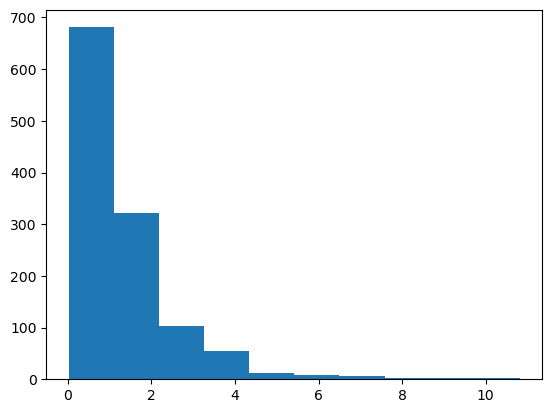

In [83]:
plt.hist(np.concatenate(list_y_true).flatten())

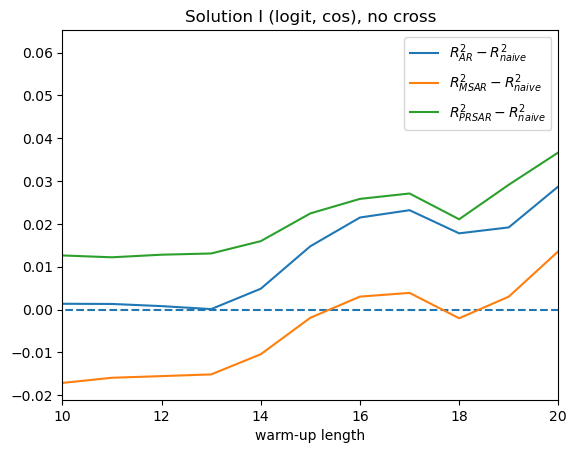

In [139]:

list_x, list_y_ar, list_y_mslr, list_y_mslrx = [], [], [], []
for cc, (tmp_r2_ar, tmp_r2_naive, tmp_rocauc_ar, tmp_rocauc_naive, tmp_r2_mslrx, tmp_r2_naive, tmp_rocauc_mslrx, tmp_rocauc_naive, tmp_r2_mslr, tmp_r2_naive, tmp_rocauc_mslr, tmp_rocauc_naive) in enumerate(list_res_logitcos_nocross):
    len_warmup = cc + 7
    list_x.append(len_warmup)
    list_y_ar.append(tmp_r2_ar - tmp_r2_naive)
    list_y_mslr.append(tmp_r2_mslr - tmp_r2_naive)
    list_y_mslrx.append(tmp_r2_mslrx - tmp_r2_naive)
    
plt.hlines(0.0, 0, 100, linestyles = "--")
plt.plot(list_x, list_y_ar, label = r'$R^2_{AR} - R^2_{naive}$')
plt.plot(list_x, list_y_mslr, label = r'$R^2_{MSAR} - R^2_{naive}$')
plt.plot(list_x, list_y_mslrx, label = r'$R^2_{PRSAR} - R^2_{naive}$')
plt.legend()
plt.xlim(10, 20)
plt.xlabel("warm-up length")
plt.title("Solution I (logit, cos), no cross")
plt.show()
    

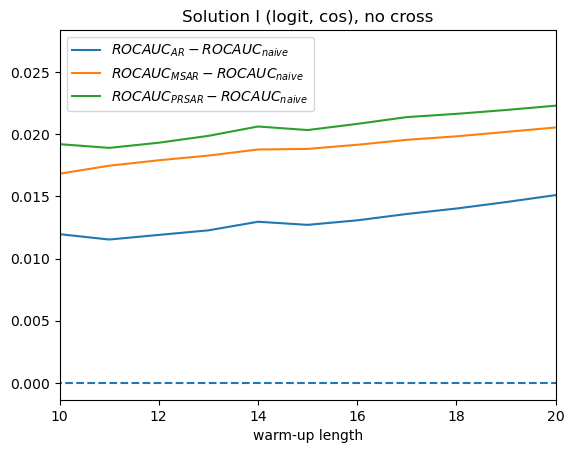

In [148]:

list_x, list_y_ar, list_y_mslr, list_y_mslrx = [], [], [], []
for cc, (tmp_r2_ar, tmp_r2_naive, tmp_rocauc_ar, tmp_rocauc_naive, tmp_r2_mslrx, tmp_r2_naive, tmp_rocauc_mslrx, tmp_rocauc_naive, tmp_r2_mslr, tmp_r2_naive, tmp_rocauc_mslr, tmp_rocauc_naive) in enumerate(list_res_logitcos_nocross):
    len_warmup = cc + 7
    list_x.append(len_warmup)
    list_y_ar.append(tmp_rocauc_ar - tmp_rocauc_naive)
    list_y_mslr.append(tmp_rocauc_mslr - tmp_rocauc_naive)
    list_y_mslrx.append(tmp_rocauc_mslrx - tmp_rocauc_naive)
    
plt.hlines(0.0, 0, 100, linestyles = "--")
plt.plot(list_x, list_y_ar, label = r'$ROCAUC_{AR} - ROCAUC_{naive}$')
plt.plot(list_x, list_y_mslr, label = r'$ROCAUC_{MSAR} - ROCAUC_{naive}$')
plt.plot(list_x, list_y_mslrx, label = r'$ROCAUC_{PRSAR} - ROCAUC_{naive}$')
plt.legend()
plt.xlim(10, 20)
plt.xlabel("warm-up length")
plt.title("Solution I (logit, cos), no cross")
plt.show()
    

#### logit-cos, with cross (flusct)

In [177]:
df_ooi = pd.read_csv("data/ooi-gi01sumo-sbd12-02-flortd000_655e_fffa_3b24.csv", skiprows=1, parse_dates=["UTC"])
df_ooi = df_ooi.rename(columns = {"UTC": "time", "m": "z", "microg.L-1": "mass_concentration_of_chlorophyll_a_in_sea_water", "m-1": "flubsct", })
del df_ooi["z"]
df_ooi = df_ooi.set_index("time")

In [178]:
array_obs = df_ooi["mass_concentration_of_chlorophyll_a_in_sea_water"].resample("1D").max().to_numpy()
array_datetime = df_ooi["mass_concentration_of_chlorophyll_a_in_sea_water"].resample("1D").max().index.to_numpy()
array_cross = df_ooi["flubsct"].resample("1D").max().to_numpy()

In [179]:
list_split_index = list(np.where(np.isnan(array_obs))[0])
list_split_index.append(len(array_obs))
list_split_index.insert(0, 0)
list_subseq = []
list_subseq_cross = []
list_subseq_datetime = []
for tmp_index in range(len(list_split_index) - 1):
    tmp_index_left = list_split_index[tmp_index] + 1
    tmp_index_right = list_split_index[tmp_index + 1]
    if tmp_index_right - tmp_index_left < 20:
        continue
    list_subseq.append(array_obs[tmp_index_left:tmp_index_right])
    list_subseq_datetime.append(array_datetime[tmp_index_left:tmp_index_right])
    list_subseq_cross.append(array_cross[tmp_index_left:tmp_index_right])

In [180]:
[len(i) for i in list_subseq]

[65, 106, 175, 184, 31, 31, 225, 148, 79, 134, 130, 59, 77]

In [181]:
list_p_AR = [1, 2, ]
list_p_AR_cross = [1, 2,]
max_p = max(max(list_p_AR), max(list_p_AR_cross))

X, Y = [], []
list_index_test_set = []
for cc, (tmp_subseq, tmp_subseq_cross, tmp_subseq_datetime) in enumerate(zip(list_subseq, list_subseq_cross, list_subseq_datetime)):
    for tmp_index_test in range(max_p, len(tmp_subseq)):
        tmp_X = []
        for tmp_p in list_p_AR:
            tmp_X.append(tmp_subseq[tmp_index_test - tmp_p])
        for tmp_p in list_p_AR_cross:
            tmp_X.append(tmp_subseq_cross[tmp_index_test - tmp_p])
        X.append(tmp_X)
        #Y.append([np.max(tmp_subseq[tmp_index_test:(tmp_index_test + 24)])])
        Y.append(tmp_subseq[tmp_index_test])
        
        if cc >= 2 and tmp_index_test >= 5:
            list_index_test_set.append(len(Y) - 1)
    

In [182]:

y_true, y_pred = [], []
y_pred_naive = []
for tmp_index in list_index_test_set:
    lr = RidgeCV()
    lr.fit(X[:tmp_index], Y[:tmp_index])
    tmp_y_pred = lr.predict([X[tmp_index]])[0]
    tmp_y_true = Y[tmp_index]
    tmp_y_pred_naive = Y[tmp_index - 1]
    y_true.append(tmp_y_true)
    y_pred.append(tmp_y_pred)
    y_pred_naive.append(tmp_y_pred_naive)


In [183]:
r2_score(y_true = y_true, y_pred = y_pred), r2_score(y_true = y_true, y_pred = y_pred_naive)

(0.737579250715549, 0.7367563288908061)

In [184]:
list_p_AR = [1, 2, ]
list_p_AR_cross = [1, 2,]
max_p = max(max(list_p_AR), max(list_p_AR_cross))

list_X, list_Y, list_exog = [], [], []
for tmp_subseq, tmp_subseq_cross, tmp_subseq_datetime in zip(list_subseq, list_subseq_cross, list_subseq_datetime):
    X, Y, exog = [], [], []
    for tmp_index_test in range(max_p, len(tmp_subseq)):
        tmp_X = []
        for tmp_p in list_p_AR:
            tmp_X.append(tmp_subseq[tmp_index_test - tmp_p])
        for tmp_p in list_p_AR_cross:
            tmp_X.append(tmp_subseq_cross[tmp_index_test - tmp_p])
        X.append(tmp_X)
        Y.append([tmp_subseq[tmp_index_test]])
        
        tmp_date= tmp_subseq_datetime[tmp_index_test]
        tmp_t = tmp_subseq_datetime[tmp_index_test].toordinal() - tmp_date.replace(month = 1, day = 1).toordinal()
        tmp_exog = [np.cos(tmp_t / 365 * 2 * np.pi)]
        exog.append(tmp_exog)
        
    list_X.append(X)
    list_Y.append(Y)
    list_exog.append(exog)
    

In [185]:
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning, DataConversionWarning
simplefilter("ignore", category=ConvergenceWarning)
simplefilter("ignore", category=DataConversionWarning)

In [186]:
list_y_true, list_y_pred_naive = [], []
list_y_pred_mslrx, list_y_pred_mslr = [], []
for cc in range(2, len(list_X)):
    tmp_list_y_true, tmp_list_y_pred_naive = [], []
    tmp_list_y_pred_mslrx, tmp_list_y_pred_mslr = [], []
    for tmp_index_test in range(5, len(list_X[cc])):
        tmp_list_X, tmp_list_Y, tmp_list_exog = [], [], []
        tmp_list_X_test = []
        for ii in range(cc):
            tmp_list_X.append(copy.deepcopy(list_X[ii]))
            tmp_list_Y.append(copy.deepcopy(list_Y[ii]))
            tmp_list_exog.append(copy.deepcopy(list_exog[ii]))
            tmp_list_X_test.append(copy.deepcopy(list_X[ii][-1]))
        tmp_list_X.append(copy.deepcopy(list_X[cc][:tmp_index_test]))
        tmp_list_Y.append(copy.deepcopy(list_Y[cc][:tmp_index_test]))
        tmp_list_exog.append(copy.deepcopy(list_exog[cc][:tmp_index_test]))
        tmp_list_X_test.append(copy.deepcopy(list_X[cc][tmp_index_test]))
        
        mslrx = MSLRX(n_components = 2, covariance_type="diag", n_iter = 10, is_logistic_regression_CV = False,
                      logistic_regression_C = 1e10, is_logistic_regression_standardized = False)
        tmp_pred = mslrx.fit_predict(tmp_list_X, tmp_list_Y, tmp_list_exog, tmp_list_X_test, is_multiple_sequence = True)
        tmp_y_pred = tmp_pred[-1]
        tmp_list_y_pred_mslrx.append(tmp_y_pred)
        
        mslr = MSLR(n_components = 2, covariance_type="diag", n_iter = 10)
        tmp_pred = mslr.fit_predict(tmp_list_X, tmp_list_Y, tmp_list_X_test, is_multiple_sequence = True)
        tmp_y_pred = tmp_pred[-1]
        tmp_list_y_pred_mslr.append(tmp_y_pred)
        
        tmp_y_true = list_Y[cc][tmp_index_test]
        tmp_y_pred_naive = list_Y[cc][tmp_index_test - 1]
        tmp_list_y_true.append(tmp_y_true)
        tmp_list_y_pred_naive.append(tmp_y_pred_naive)
        
    list_y_true.append(tmp_list_y_true)
    list_y_pred_naive.append(tmp_list_y_pred_naive)
    list_y_pred_mslrx.append(tmp_list_y_pred_mslrx)
    list_y_pred_mslr.append(tmp_list_y_pred_mslr)
        

d:\Tools\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
d:\Tools\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
d:\Tools\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
d:\Tools\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there a

In [187]:
thres = 2.0

list_p_AR = [1, 2, ]
list_p_AR_cross = [1, 2,]
max_p = max(max(list_p_AR), max(list_p_AR_cross))

list_res_logitcos_cross = []
for start_index in range(7, 30):
    
    print(start_index)
    
    X, Y = [], []
    list_index_test_set = []
    for cc, (tmp_subseq, tmp_subseq_cross, tmp_subseq_datetime) in enumerate(zip(list_subseq, list_subseq_cross, list_subseq_datetime)):
        for tmp_index_test in range(max_p, len(tmp_subseq)):
            tmp_X = []
            tmp_date = tmp_subseq_datetime[tmp_index_test]
            tmp_t = tmp_subseq_datetime[tmp_index_test].toordinal() - tmp_date.replace(month = 1, day = 1).toordinal()
            tmp_X.append(np.cos(tmp_t / 365 * 2 * np.pi))
            for tmp_p in list_p_AR:
                tmp_X.append(tmp_subseq[tmp_index_test - tmp_p])
            for tmp_p in list_p_AR_cross:
                tmp_X.append(tmp_subseq_cross[tmp_index_test - tmp_p])
            X.append(tmp_X)
            Y.append(tmp_subseq[tmp_index_test])

            if cc >= 2 and tmp_index_test >= start_index:
                list_index_test_set.append(len(Y) - 1)
                
    y_true, y_pred = [], []
    y_pred_naive = []
    for tmp_index in list_index_test_set:
        lr = LinearRegression()
        #lr = LinearSVR()
        lr.fit(X[:tmp_index], Y[:tmp_index])
        tmp_y_pred = lr.predict([X[tmp_index]])[0]
        tmp_y_true = Y[tmp_index]
        tmp_y_pred_naive = Y[tmp_index - 1]
        y_true.append(tmp_y_true)
        y_pred.append(tmp_y_pred)
        y_pred_naive.append(tmp_y_pred_naive)

    tmp_r2_ar, tmp_r2_naive, tmp_rocauc_ar, tmp_rocauc_naive = r2_score(y_true = y_true, y_pred = y_pred), r2_score(y_true = y_true, y_pred = y_pred_naive), \
          roc_auc_score(y_true = np.array(y_true) > thres, y_score=y_pred), roc_auc_score(y_true = np.array(y_true) > thres, y_score=y_pred_naive)
    print(tmp_r2_ar, tmp_r2_naive, tmp_rocauc_ar, tmp_rocauc_naive)
    
    y_true, y_pred = [], []
    y_pred_naive = []
    for cc in range(0, len(list_y_true)):
        for tmp_index_test in range(start_index - 5 - 2, len(list_y_true[cc])):
            y_true.append(list_y_true[cc][tmp_index_test])
            y_pred.append(list_y_pred_mslrx[cc][tmp_index_test])
            y_pred_naive.append(list_y_pred_naive[cc][tmp_index_test])
            
    tmp_r2_mslrx, tmp_r2_naive, tmp_rocauc_mslrx, tmp_rocauc_naive = r2_score(y_true = y_true, y_pred = y_pred), r2_score(y_true = y_true, y_pred = y_pred_naive), \
          roc_auc_score(y_true = np.array(y_true) > thres, y_score=y_pred), roc_auc_score(y_true = np.array(y_true) > thres, y_score=y_pred_naive)
    print(tmp_r2_mslrx, tmp_r2_naive, tmp_rocauc_mslrx, tmp_rocauc_naive)
    
    y_true, y_pred = [], []
    y_pred_naive = []
    for cc in range(0, len(list_y_true)):
        for tmp_index_test in range(start_index - 5 - 2, len(list_y_true[cc])):
            y_true.append(list_y_true[cc][tmp_index_test])
            y_pred.append(list_y_pred_mslr[cc][tmp_index_test])
            y_pred_naive.append(list_y_pred_naive[cc][tmp_index_test])
            
    tmp_r2_mslr, tmp_r2_naive, tmp_rocauc_mslr, tmp_rocauc_naive = r2_score(y_true = y_true, y_pred = y_pred), r2_score(y_true = y_true, y_pred = y_pred_naive), \
          roc_auc_score(y_true = np.array(y_true) > thres, y_score=y_pred), roc_auc_score(y_true = np.array(y_true) > thres, y_score=y_pred_naive)
    print(tmp_r2_mslr, tmp_r2_naive, tmp_rocauc_mslr, tmp_rocauc_naive)
    
    list_res_logitcos_cross.append((tmp_r2_ar, tmp_r2_naive, tmp_rocauc_ar, tmp_rocauc_naive, tmp_r2_mslrx, tmp_r2_naive, tmp_rocauc_mslrx, tmp_rocauc_naive, tmp_r2_mslr, tmp_r2_naive, tmp_rocauc_mslr, tmp_rocauc_naive))
    

7
0.734398648227054 0.7330392195960626 0.9369126904479519 0.927987866070614
0.7526031159647336 0.7330392195960626 0.9440653225070705 0.927987866070614
0.7289609005014985 0.7330392195960626 0.9438965422862877 0.927987866070614
8
0.7359624544667356 0.7370556353652442 0.9374814181656013 0.9279605507655717
0.7544163717906108 0.7370556353652442 0.9443427605173182 0.9279605507655717
0.7292354267852081 0.7370556353652442 0.9438271146127546 0.9279605507655717
9
0.7399772432307297 0.7379790270513338 0.9390492896314004 0.9281497408911082
0.7570786422096124 0.7379790270513338 0.9454668911176811 0.9281497408911082
0.7316329889536513 0.7379790270513338 0.9445285349855945 0.9281497408911082
10
0.7405557080489364 0.7402707055082842 0.9393799656070169 0.9282670932165126
0.7574392663762618 0.7402707055082842 0.945480396960352 0.9282670932165126
0.7315631629484062 0.7402707055082842 0.9443179525607401 0.9282670932165126
11
0.7410964223279541 0.7409740773063224 0.9389819853446751 0.9283097263422588
0.757

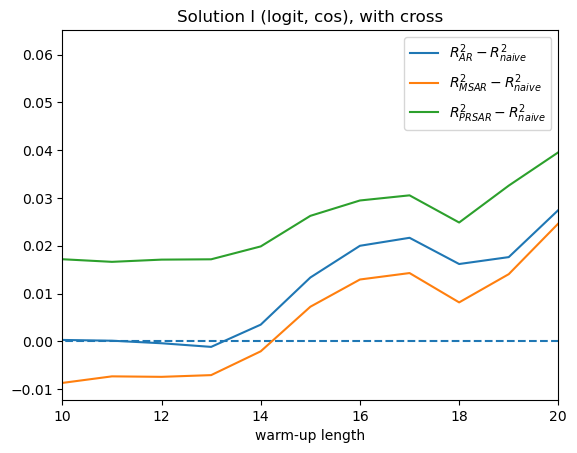

In [188]:
list_x, list_y_ar, list_y_mslr, list_y_mslrx = [], [], [], []
for cc, (tmp_r2_ar, tmp_r2_naive, tmp_rocauc_ar, tmp_rocauc_naive, tmp_r2_mslrx, tmp_r2_naive, tmp_rocauc_mslrx, tmp_rocauc_naive, tmp_r2_mslr, tmp_r2_naive, tmp_rocauc_mslr, tmp_rocauc_naive) in enumerate(list_res_logitcos_cross):
    len_warmup = cc + 7
    list_x.append(len_warmup)
    list_y_ar.append(tmp_r2_ar - tmp_r2_naive)
    list_y_mslr.append(tmp_r2_mslr - tmp_r2_naive)
    list_y_mslrx.append(tmp_r2_mslrx - tmp_r2_naive)
    
plt.hlines(0.0, 0, 100, linestyles = "--")
plt.plot(list_x, list_y_ar, label = r'$R^2_{AR} - R^2_{naive}$')
plt.plot(list_x, list_y_mslr, label = r'$R^2_{MSAR} - R^2_{naive}$')
plt.plot(list_x, list_y_mslrx, label = r'$R^2_{PRSAR} - R^2_{naive}$')
plt.legend()
plt.xlim(10, 20)
plt.xlabel("warm-up length")
plt.title("Solution I (logit, cos), with cross")
plt.show()


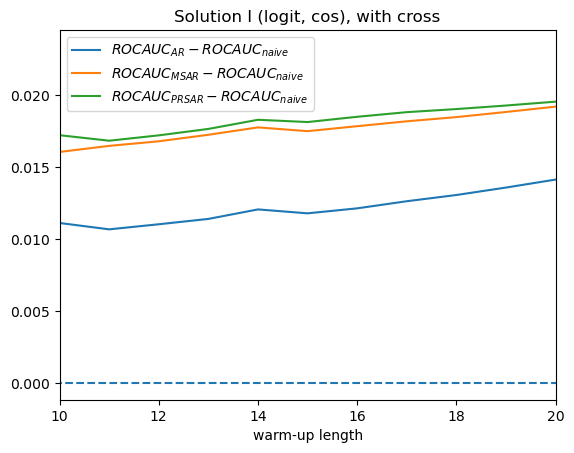

In [189]:

list_x, list_y_ar, list_y_mslr, list_y_mslrx = [], [], [], []
for cc, (tmp_r2_ar, tmp_r2_naive, tmp_rocauc_ar, tmp_rocauc_naive, tmp_r2_mslrx, tmp_r2_naive, tmp_rocauc_mslrx, tmp_rocauc_naive, tmp_r2_mslr, tmp_r2_naive, tmp_rocauc_mslr, tmp_rocauc_naive) in enumerate(list_res_logitcos_cross):
    len_warmup = cc + 7
    list_x.append(len_warmup)
    list_y_ar.append(tmp_rocauc_ar - tmp_rocauc_naive)
    list_y_mslr.append(tmp_rocauc_mslr - tmp_rocauc_naive)
    list_y_mslrx.append(tmp_rocauc_mslrx - tmp_rocauc_naive)
    
plt.hlines(0.0, 0, 100, linestyles = "--")
plt.plot(list_x, list_y_ar, label = r'$ROCAUC_{AR} - ROCAUC_{naive}$')
plt.plot(list_x, list_y_mslr, label = r'$ROCAUC_{MSAR} - ROCAUC_{naive}$')
plt.plot(list_x, list_y_mslrx, label = r'$ROCAUC_{PRSAR} - ROCAUC_{naive}$')
plt.legend()
plt.xlim(10, 20)
plt.xlabel("warm-up length")
plt.title("Solution I (logit, cos), with cross")
plt.show()
    

#### logit-onehot, no cross (flusct)

In [114]:
df_ooi = pd.read_csv("data/ooi-gi01sumo-sbd12-02-flortd000_655e_fffa_3b24.csv", skiprows=1, parse_dates=["UTC"])
df_ooi = df_ooi.rename(columns = {"UTC": "time", "m": "z", "microg.L-1": "mass_concentration_of_chlorophyll_a_in_sea_water", "m-1": "flubsct", })
del df_ooi["z"]
df_ooi = df_ooi.set_index("time")

In [115]:
array_obs = df_ooi["mass_concentration_of_chlorophyll_a_in_sea_water"].resample("1D").max().to_numpy()
array_datetime = df_ooi["mass_concentration_of_chlorophyll_a_in_sea_water"].resample("1D").max().index.to_numpy()

In [116]:
list_split_index = list(np.where(np.isnan(array_obs))[0])
list_split_index.append(len(array_obs))
list_split_index.insert(0, 0)
list_subseq = []
#list_subseq_cross = []
list_subseq_datetime = []
for tmp_index in range(len(list_split_index) - 1):
    tmp_index_left = list_split_index[tmp_index] + 1
    tmp_index_right = list_split_index[tmp_index + 1]
    if tmp_index_right - tmp_index_left < 20:
        continue
    list_subseq.append(array_obs[tmp_index_left:tmp_index_right])
    list_subseq_datetime.append(array_datetime[tmp_index_left:tmp_index_right])
    #list_subseq_cross.append(array_cross[tmp_index_left:tmp_index_right])

In [117]:
[len(i) for i in list_subseq]

[65, 106, 175, 184, 31, 31, 225, 148, 79, 134, 130, 59, 77]

In [118]:
list_p_AR = [1, 2, ]
max_p = max(list_p_AR)

X, Y = [], []
list_index_test_set = []
for cc, (tmp_subseq, tmp_subseq_datetime) in enumerate(zip(list_subseq, list_subseq_datetime)):
    for tmp_index_test in range(max_p, len(tmp_subseq)):
        tmp_X = []
        for tmp_p in list_p_AR:
            tmp_X.append(tmp_subseq[tmp_index_test - tmp_p])
        X.append(tmp_X)
        #Y.append([np.max(tmp_subseq[tmp_index_test:(tmp_index_test + 24)])])
        Y.append(tmp_subseq[tmp_index_test])
        
        if cc >= 2 and tmp_index_test >= 5:
            list_index_test_set.append(len(Y) - 1)
    

In [119]:

y_true, y_pred = [], []
y_pred_naive = []
for tmp_index in list_index_test_set:
    lr = RidgeCV()
    lr.fit(X[:tmp_index], Y[:tmp_index])
    tmp_y_pred = lr.predict([X[tmp_index]])[0]
    tmp_y_true = Y[tmp_index]
    tmp_y_pred_naive = Y[tmp_index - 1]
    y_true.append(tmp_y_true)
    y_pred.append(tmp_y_pred)
    y_pred_naive.append(tmp_y_pred_naive)


In [120]:
r2_score(y_true = y_true, y_pred = y_pred), r2_score(y_true = y_true, y_pred = y_pred_naive)

(0.7348928368999419, 0.7367563288908061)

In [121]:
list_p_AR = [1, 2, ]
max_p = max(list_p_AR)

list_X, list_Y, list_exog = [], [], []
for tmp_subseq, tmp_subseq_datetime in zip(list_subseq, list_subseq_datetime):
    X, Y, exog = [], [], []
    for tmp_index_test in range(max_p, len(tmp_subseq)):
        tmp_X = []
        for tmp_p in list_p_AR:
            tmp_X.append(tmp_subseq[tmp_index_test - tmp_p])
        X.append(tmp_X)
        Y.append([tmp_subseq[tmp_index_test]])
        
        tmp_date= tmp_subseq_datetime[tmp_index_test]
        tmp_t = tmp_subseq_datetime[tmp_index_test].toordinal() - tmp_date.replace(month = 1, day = 1).toordinal()
        #tmp_exog = [np.cos(tmp_t / 365 * 2 * np.pi)]
        tmp_phase = tmp_t / 365
        tmp_exog = [int(tmp_phase < 0.25), int(0.25 <= tmp_phase < 0.5), int(0.5 <= tmp_phase < 0.75), int(tmp_phase >= 0.75)]
        exog.append(tmp_exog)
        
    list_X.append(X)
    list_Y.append(Y)
    list_exog.append(exog)
    

In [122]:
list_y_true, list_y_pred_naive = [], []
list_y_pred_mslrx, list_y_pred_mslr = [], []
for cc in range(2, len(list_X)):
    tmp_list_y_true, tmp_list_y_pred_naive = [], []
    tmp_list_y_pred_mslrx, tmp_list_y_pred_mslr = [], []
    for tmp_index_test in range(5, len(list_X[cc])):
        tmp_list_X, tmp_list_Y, tmp_list_exog = [], [], []
        tmp_list_X_test = []
        for ii in range(cc):
            tmp_list_X.append(copy.deepcopy(list_X[ii]))
            tmp_list_Y.append(copy.deepcopy(list_Y[ii]))
            tmp_list_exog.append(copy.deepcopy(list_exog[ii]))
            tmp_list_X_test.append(copy.deepcopy(list_X[ii][-1]))
        tmp_list_X.append(copy.deepcopy(list_X[cc][:tmp_index_test]))
        tmp_list_Y.append(copy.deepcopy(list_Y[cc][:tmp_index_test]))
        tmp_list_exog.append(copy.deepcopy(list_exog[cc][:tmp_index_test]))
        tmp_list_X_test.append(copy.deepcopy(list_X[cc][tmp_index_test]))
        
        mslrx = MSLRX(n_components = 2, covariance_type="diag", n_iter = 10, is_logistic_regression_CV = False,
                      logistic_regression_C = 1e10, is_logistic_regression_standardized = False)
        tmp_pred = mslrx.fit_predict(tmp_list_X, tmp_list_Y, tmp_list_exog, tmp_list_X_test, is_multiple_sequence = True)
        tmp_y_pred = tmp_pred[-1]
        tmp_list_y_pred_mslrx.append(tmp_y_pred)
        
        mslr = MSLR(n_components = 2, covariance_type="diag", n_iter = 10)
        tmp_pred = mslr.fit_predict(tmp_list_X, tmp_list_Y, tmp_list_X_test, is_multiple_sequence = True)
        tmp_y_pred = tmp_pred[-1]
        tmp_list_y_pred_mslr.append(tmp_y_pred)
        
        tmp_y_true = list_Y[cc][tmp_index_test]
        tmp_y_pred_naive = list_Y[cc][tmp_index_test - 1]
        tmp_list_y_true.append(tmp_y_true)
        tmp_list_y_pred_naive.append(tmp_y_pred_naive)
        
    list_y_true.append(tmp_list_y_true)
    list_y_pred_naive.append(tmp_list_y_pred_naive)
    list_y_pred_mslrx.append(tmp_list_y_pred_mslrx)
    list_y_pred_mslr.append(tmp_list_y_pred_mslr)
        

d:\Tools\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
d:\Tools\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
d:\Tools\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
d:\Tools\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there a

In [123]:
thres = 2.0

list_p_AR = [1, 2, ]
max_p = max(list_p_AR)

list_res_logitonehot_nocross = []

for start_index in range(7, 30):
    
    print(start_index)
    
    X, Y = [], []
    list_index_test_set = []
    for cc, (tmp_subseq, tmp_subseq_datetime) in enumerate(zip(list_subseq, list_subseq_datetime)):
        for tmp_index_test in range(max_p, len(tmp_subseq)):
            tmp_X = []
            tmp_date= tmp_subseq_datetime[tmp_index_test]
            tmp_t = tmp_subseq_datetime[tmp_index_test].toordinal() - tmp_date.replace(month = 1, day = 1).toordinal()
            tmp_phase = tmp_t / 365
            tmp_X.extend([int(tmp_phase < 0.25), int(0.25 <= tmp_phase < 0.5), int(0.5 <= tmp_phase < 0.75)])
            for tmp_p in list_p_AR:
                tmp_X.append(tmp_subseq[tmp_index_test - tmp_p])
            X.append(tmp_X)
            #Y.append([np.max(tmp_subseq[tmp_index_test:(tmp_index_test + 24)])])
            Y.append(tmp_subseq[tmp_index_test])

            if cc >= 2 and tmp_index_test >= start_index:
                list_index_test_set.append(len(Y) - 1)
                
    y_true, y_pred = [], []
    y_pred_naive = []
    for tmp_index in list_index_test_set:
        lr = LinearRegression()
        lr.fit(X[:tmp_index], Y[:tmp_index])
        tmp_y_pred = lr.predict([X[tmp_index]])[0]
        tmp_y_true = Y[tmp_index]
        tmp_y_pred_naive = Y[tmp_index - 1]
        y_true.append(tmp_y_true)
        y_pred.append(tmp_y_pred)
        y_pred_naive.append(tmp_y_pred_naive)

    tmp_r2_ar, tmp_r2_naive, tmp_rocauc_ar, tmp_rocauc_naive = r2_score(y_true = y_true, y_pred = y_pred), r2_score(y_true = y_true, y_pred = y_pred_naive), \
          roc_auc_score(y_true = np.array(y_true) > thres, y_score=y_pred), roc_auc_score(y_true = np.array(y_true) > thres, y_score=y_pred_naive)
    print(tmp_r2_ar, tmp_r2_naive, tmp_rocauc_ar, tmp_rocauc_naive)
    
    y_true, y_pred = [], []
    y_pred_naive = []
    for cc in range(0, len(list_y_true)):
        for tmp_index_test in range(start_index - 5 - 2, len(list_y_true[cc])):
            y_true.append(list_y_true[cc][tmp_index_test])
            y_pred.append(list_y_pred_mslrx[cc][tmp_index_test])
            y_pred_naive.append(list_y_pred_naive[cc][tmp_index_test])
            
    tmp_r2_mslrx, tmp_r2_naive, tmp_rocauc_mslrx, tmp_rocauc_naive = r2_score(y_true = y_true, y_pred = y_pred), r2_score(y_true = y_true, y_pred = y_pred_naive), \
          roc_auc_score(y_true = np.array(y_true) > thres, y_score=y_pred), roc_auc_score(y_true = np.array(y_true) > thres, y_score=y_pred_naive)
    print(tmp_r2_mslrx, tmp_r2_naive, tmp_rocauc_mslrx, tmp_rocauc_naive)
    
    y_true, y_pred = [], []
    y_pred_naive = []
    for cc in range(0, len(list_y_true)):
        for tmp_index_test in range(start_index - 5 - 2, len(list_y_true[cc])):
            y_true.append(list_y_true[cc][tmp_index_test])
            y_pred.append(list_y_pred_mslr[cc][tmp_index_test])
            y_pred_naive.append(list_y_pred_naive[cc][tmp_index_test])
            
    tmp_r2_mslr, tmp_r2_naive, tmp_rocauc_mslr, tmp_rocauc_naive = r2_score(y_true = y_true, y_pred = y_pred), r2_score(y_true = y_true, y_pred = y_pred_naive), \
          roc_auc_score(y_true = np.array(y_true) > thres, y_score=y_pred), roc_auc_score(y_true = np.array(y_true) > thres, y_score=y_pred_naive)
    print(tmp_r2_mslr, tmp_r2_naive, tmp_rocauc_mslr, tmp_rocauc_naive)
    
    list_res_logitonehot_nocross.append((tmp_r2_ar, tmp_r2_naive, tmp_rocauc_ar, tmp_rocauc_naive, tmp_r2_mslrx, tmp_r2_naive, tmp_rocauc_mslrx, tmp_rocauc_naive, tmp_r2_mslr, tmp_r2_naive, tmp_rocauc_mslr, tmp_rocauc_naive))
    

7
0.7293035999797222 0.7330392195960626 0.9396633518839523 0.927987866070614
0.7300324490916821 0.7330392195960626 0.9429203539823009 0.927987866070614
0.7207031499121151 0.7330392195960626 0.9450095794179362 0.927987866070614
8
0.732092271152251 0.7370556353652442 0.9401479114018136 0.9279605507655717
0.7308105580623099 0.7370556353652442 0.9429212501858184 0.9279605507655717
0.7208982536774078 0.7370556353652442 0.9448491155046828 0.9279605507655717
9
0.7375681229261113 0.7379790270513338 0.9415814365808 0.9281497408911082
0.7331101739657347 0.7379790270513338 0.9438589542280252 0.9281497408911082
0.723641168967558 0.7379790270513338 0.9455847750538731 0.9281497408911082
10
0.7374273720937103 0.7402707055082842 0.941488697389784 0.9282670932165126
0.7335037172199832 0.7402707055082842 0.9438616210815537 0.9282670932165126
0.7231682183382813 0.7402707055082842 0.9451537596910395 0.9282670932165126
11
0.737145374104502 0.7409740773063224 0.9410103530243797 0.9283097263422588
0.73506401

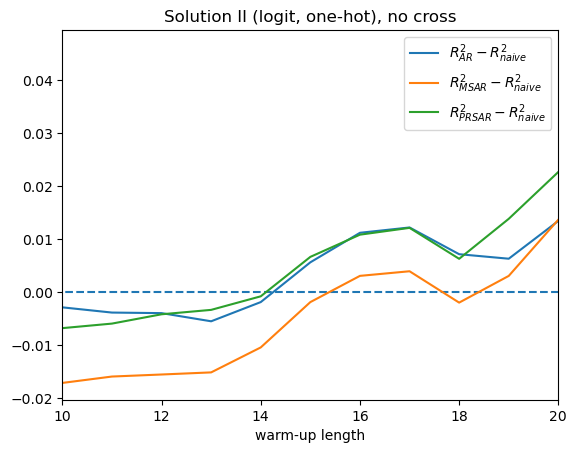

In [137]:
list_x, list_y_ar, list_y_mslr, list_y_mslrx = [], [], [], []
for cc, (tmp_r2_ar, tmp_r2_naive, tmp_rocauc_ar, tmp_rocauc_naive, tmp_r2_mslrx, tmp_r2_naive, tmp_rocauc_mslrx, tmp_rocauc_naive, tmp_r2_mslr, tmp_r2_naive, tmp_rocauc_mslr, tmp_rocauc_naive) in enumerate(list_res_logitonehot_nocross):
    len_warmup = cc + 7
    list_x.append(len_warmup)
    list_y_ar.append(tmp_r2_ar - tmp_r2_naive)
    list_y_mslr.append(tmp_r2_mslr - tmp_r2_naive)
    list_y_mslrx.append(tmp_r2_mslrx - tmp_r2_naive)
    
plt.hlines(0.0, 0, 100, linestyles = "--")
plt.plot(list_x, list_y_ar, label = r'$R^2_{AR} - R^2_{naive}$')
plt.plot(list_x, list_y_mslr, label = r'$R^2_{MSAR} - R^2_{naive}$')
plt.plot(list_x, list_y_mslrx, label = r'$R^2_{PRSAR} - R^2_{naive}$')
plt.legend()
plt.xlim(10, 20)
plt.xlabel("warm-up length")
plt.title("Solution II (logit, one-hot), no cross")
plt.show()


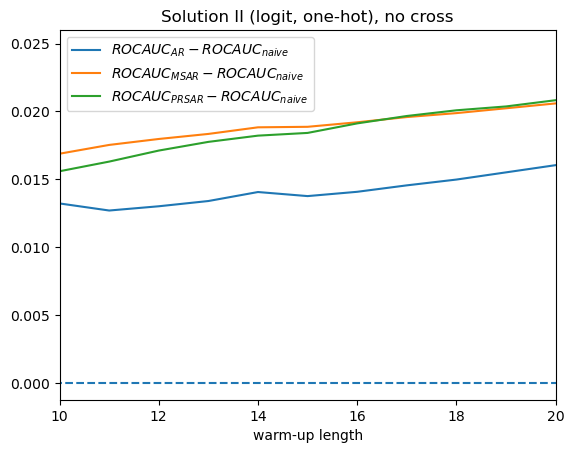

In [146]:

list_x, list_y_ar, list_y_mslr, list_y_mslrx = [], [], [], []
for cc, (tmp_r2_ar, tmp_r2_naive, tmp_rocauc_ar, tmp_rocauc_naive, tmp_r2_mslrx, tmp_r2_naive, tmp_rocauc_mslrx, tmp_rocauc_naive, tmp_r2_mslr, tmp_r2_naive, tmp_rocauc_mslr, tmp_rocauc_naive) in enumerate(list_res_logitonehot_nocross):
    len_warmup = cc + 7
    list_x.append(len_warmup)
    list_y_ar.append(tmp_rocauc_ar - tmp_rocauc_naive)
    list_y_mslr.append(tmp_rocauc_mslr - tmp_rocauc_naive)
    list_y_mslrx.append(tmp_rocauc_mslrx - tmp_rocauc_naive)
    
plt.hlines(0.0, 0, 100, linestyles = "--")
plt.plot(list_x, list_y_ar, label = r'$ROCAUC_{AR} - ROCAUC_{naive}$')
plt.plot(list_x, list_y_mslr, label = r'$ROCAUC_{MSAR} - ROCAUC_{naive}$')
plt.plot(list_x, list_y_mslrx, label = r'$ROCAUC_{PRSAR} - ROCAUC_{naive}$')
plt.legend()
plt.xlim(10, 20)
plt.xlabel("warm-up length")
plt.title("Solution II (logit, one-hot), no cross")
plt.show()
    

#### logit-onehot, with cross (flusct)

In [125]:
df_ooi = pd.read_csv("data/ooi-gi01sumo-sbd12-02-flortd000_655e_fffa_3b24.csv", skiprows=1, parse_dates=["UTC"])
df_ooi = df_ooi.rename(columns = {"UTC": "time", "m": "z", "microg.L-1": "mass_concentration_of_chlorophyll_a_in_sea_water", "m-1": "flubsct", })
del df_ooi["z"]
df_ooi = df_ooi.set_index("time")

In [126]:
array_obs = df_ooi["mass_concentration_of_chlorophyll_a_in_sea_water"].resample("1D").max().to_numpy()
array_datetime = df_ooi["mass_concentration_of_chlorophyll_a_in_sea_water"].resample("1D").max().index.to_numpy()
array_cross = df_ooi["flubsct"].resample("1D").max().to_numpy()

In [127]:
list_split_index = list(np.where(np.isnan(array_obs))[0])
list_split_index.append(len(array_obs))
list_split_index.insert(0, 0)
list_subseq = []
list_subseq_cross = []
list_subseq_datetime = []
for tmp_index in range(len(list_split_index) - 1):
    tmp_index_left = list_split_index[tmp_index] + 1
    tmp_index_right = list_split_index[tmp_index + 1]
    if tmp_index_right - tmp_index_left < 20:
        continue
    list_subseq.append(array_obs[tmp_index_left:tmp_index_right])
    list_subseq_datetime.append(array_datetime[tmp_index_left:tmp_index_right])
    list_subseq_cross.append(array_cross[tmp_index_left:tmp_index_right])

In [128]:
[len(i) for i in list_subseq]

[65, 106, 175, 184, 31, 31, 225, 148, 79, 134, 130, 59, 77]

In [129]:
list_p_AR = [1, 2, ]
list_p_AR_cross = [1, 2,]
max_p = max(max(list_p_AR), max(list_p_AR_cross))

X, Y = [], []
list_index_test_set = []
for cc, (tmp_subseq, tmp_subseq_cross, tmp_subseq_datetime) in enumerate(zip(list_subseq, list_subseq_cross, list_subseq_datetime)):
    for tmp_index_test in range(max_p, len(tmp_subseq)):
        tmp_X = []
        for tmp_p in list_p_AR:
            tmp_X.append(tmp_subseq[tmp_index_test - tmp_p])
        for tmp_p in list_p_AR_cross:
            tmp_X.append(tmp_subseq_cross[tmp_index_test - tmp_p])
        X.append(tmp_X)
        #Y.append([np.max(tmp_subseq[tmp_index_test:(tmp_index_test + 24)])])
        Y.append(tmp_subseq[tmp_index_test])
        
        if cc >= 2 and tmp_index_test >= 5:
            list_index_test_set.append(len(Y) - 1)
    

In [130]:

y_true, y_pred = [], []
y_pred_naive = []
for tmp_index in list_index_test_set:
    lr = RidgeCV()
    lr.fit(X[:tmp_index], Y[:tmp_index])
    tmp_y_pred = lr.predict([X[tmp_index]])[0]
    tmp_y_true = Y[tmp_index]
    tmp_y_pred_naive = Y[tmp_index - 1]
    y_true.append(tmp_y_true)
    y_pred.append(tmp_y_pred)
    y_pred_naive.append(tmp_y_pred_naive)


In [131]:
r2_score(y_true = y_true, y_pred = y_pred), r2_score(y_true = y_true, y_pred = y_pred_naive)

(0.737579250715549, 0.7367563288908061)

In [132]:
list_p_AR = [1, 2, ]
list_p_AR_cross = [1, 2,]
max_p = max(max(list_p_AR), max(list_p_AR_cross))

list_X, list_Y, list_exog = [], [], []
for tmp_subseq, tmp_subseq_cross, tmp_subseq_datetime in zip(list_subseq, list_subseq_cross, list_subseq_datetime):
    X, Y, exog = [], [], []
    for tmp_index_test in range(max_p, len(tmp_subseq)):
        tmp_X = []
        for tmp_p in list_p_AR:
            tmp_X.append(tmp_subseq[tmp_index_test - tmp_p])
        for tmp_p in list_p_AR_cross:
            tmp_X.append(tmp_subseq_cross[tmp_index_test - tmp_p])
        X.append(tmp_X)
        Y.append([tmp_subseq[tmp_index_test]])
        
        tmp_date= tmp_subseq_datetime[tmp_index_test]
        tmp_t = tmp_subseq_datetime[tmp_index_test].toordinal() - tmp_date.replace(month = 1, day = 1).toordinal()
        tmp_phase = tmp_t / 365
        tmp_exog = [int(tmp_phase < 0.25), int(0.25 <= tmp_phase < 0.5), int(0.5 <= tmp_phase < 0.75), int(tmp_phase >= 0.75)]
        exog.append(tmp_exog)
        
    list_X.append(X)
    list_Y.append(Y)
    list_exog.append(exog)
    

In [133]:
list_y_true, list_y_pred_naive = [], []
list_y_pred_mslrx, list_y_pred_mslr = [], []
for cc in range(2, len(list_X)):
    tmp_list_y_true, tmp_list_y_pred_naive = [], []
    tmp_list_y_pred_mslrx, tmp_list_y_pred_mslr = [], []
    for tmp_index_test in range(5, len(list_X[cc])):
        tmp_list_X, tmp_list_Y, tmp_list_exog = [], [], []
        tmp_list_X_test = []
        for ii in range(cc):
            tmp_list_X.append(copy.deepcopy(list_X[ii]))
            tmp_list_Y.append(copy.deepcopy(list_Y[ii]))
            tmp_list_exog.append(copy.deepcopy(list_exog[ii]))
            tmp_list_X_test.append(copy.deepcopy(list_X[ii][-1]))
        tmp_list_X.append(copy.deepcopy(list_X[cc][:tmp_index_test]))
        tmp_list_Y.append(copy.deepcopy(list_Y[cc][:tmp_index_test]))
        tmp_list_exog.append(copy.deepcopy(list_exog[cc][:tmp_index_test]))
        tmp_list_X_test.append(copy.deepcopy(list_X[cc][tmp_index_test]))
        
        mslrx = MSLRX(n_components = 2, covariance_type="diag", n_iter = 10, is_logistic_regression_CV = False,
                      logistic_regression_C = 1e10, is_logistic_regression_standardized = False)
        tmp_pred = mslrx.fit_predict(tmp_list_X, tmp_list_Y, tmp_list_exog, tmp_list_X_test, is_multiple_sequence = True)
        tmp_y_pred = tmp_pred[-1]
        tmp_list_y_pred_mslrx.append(tmp_y_pred)
        
        mslr = MSLR(n_components = 2, covariance_type="diag", n_iter = 10)
        tmp_pred = mslr.fit_predict(tmp_list_X, tmp_list_Y, tmp_list_X_test, is_multiple_sequence = True)
        tmp_y_pred = tmp_pred[-1]
        tmp_list_y_pred_mslr.append(tmp_y_pred)
        
        tmp_y_true = list_Y[cc][tmp_index_test]
        tmp_y_pred_naive = list_Y[cc][tmp_index_test - 1]
        tmp_list_y_true.append(tmp_y_true)
        tmp_list_y_pred_naive.append(tmp_y_pred_naive)
        
    list_y_true.append(tmp_list_y_true)
    list_y_pred_naive.append(tmp_list_y_pred_naive)
    list_y_pred_mslrx.append(tmp_list_y_pred_mslrx)
    list_y_pred_mslr.append(tmp_list_y_pred_mslr)
        

d:\Tools\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
d:\Tools\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
d:\Tools\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
d:\Tools\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there a

In [134]:
thres = 2.0

list_p_AR = [1, 2, ]
list_p_AR_cross = [1, 2,]
max_p = max(max(list_p_AR), max(list_p_AR_cross))

list_res_logitonehot_cross = []

for start_index in range(7, 30):
    
    print(start_index)
    
    X, Y = [], []
    list_index_test_set = []
    for cc, (tmp_subseq, tmp_subseq_cross, tmp_subseq_datetime) in enumerate(zip(list_subseq, list_subseq_cross, list_subseq_datetime)):
        for tmp_index_test in range(max_p, len(tmp_subseq)):
            tmp_X = []
            tmp_date = tmp_subseq_datetime[tmp_index_test]
            tmp_t = tmp_subseq_datetime[tmp_index_test].toordinal() - tmp_date.replace(month = 1, day = 1).toordinal()
            tmp_phase = tmp_t / 365
            tmp_X.extend([int(tmp_phase < 0.25), int(0.25 <= tmp_phase < 0.5), int(0.5 <= tmp_phase < 0.75)])
            for tmp_p in list_p_AR:
                tmp_X.append(tmp_subseq[tmp_index_test - tmp_p])
            for tmp_p in list_p_AR_cross:
                tmp_X.append(tmp_subseq_cross[tmp_index_test - tmp_p])
            X.append(tmp_X)
            Y.append(tmp_subseq[tmp_index_test])

            if cc >= 2 and tmp_index_test >= start_index:
                list_index_test_set.append(len(Y) - 1)
                
    y_true, y_pred = [], []
    y_pred_naive = []
    for tmp_index in list_index_test_set:
        lr = LinearRegression()
        lr.fit(X[:tmp_index], Y[:tmp_index])
        tmp_y_pred = lr.predict([X[tmp_index]])[0]
        tmp_y_true = Y[tmp_index]
        tmp_y_pred_naive = Y[tmp_index - 1]
        y_true.append(tmp_y_true)
        y_pred.append(tmp_y_pred)
        y_pred_naive.append(tmp_y_pred_naive)

    tmp_r2_ar, tmp_r2_naive, tmp_rocauc_ar, tmp_rocauc_naive = r2_score(y_true = y_true, y_pred = y_pred), r2_score(y_true = y_true, y_pred = y_pred_naive), \
          roc_auc_score(y_true = np.array(y_true) > thres, y_score=y_pred), roc_auc_score(y_true = np.array(y_true) > thres, y_score=y_pred_naive)
    print(tmp_r2_ar, tmp_r2_naive, tmp_rocauc_ar, tmp_rocauc_naive)
    
    y_true, y_pred = [], []
    y_pred_naive = []
    for cc in range(0, len(list_y_true)):
        for tmp_index_test in range(start_index - 5 - 2, len(list_y_true[cc])):
            y_true.append(list_y_true[cc][tmp_index_test])
            y_pred.append(list_y_pred_mslrx[cc][tmp_index_test])
            y_pred_naive.append(list_y_pred_naive[cc][tmp_index_test])
            
    tmp_r2_mslrx, tmp_r2_naive, tmp_rocauc_mslrx, tmp_rocauc_naive = r2_score(y_true = y_true, y_pred = y_pred), r2_score(y_true = y_true, y_pred = y_pred_naive), \
          roc_auc_score(y_true = np.array(y_true) > thres, y_score=y_pred), roc_auc_score(y_true = np.array(y_true) > thres, y_score=y_pred_naive)
    print(tmp_r2_mslrx, tmp_r2_naive, tmp_rocauc_mslrx, tmp_rocauc_naive)
    
    y_true, y_pred = [], []
    y_pred_naive = []
    for cc in range(0, len(list_y_true)):
        for tmp_index_test in range(start_index - 5 - 2, len(list_y_true[cc])):
            y_true.append(list_y_true[cc][tmp_index_test])
            y_pred.append(list_y_pred_mslr[cc][tmp_index_test])
            y_pred_naive.append(list_y_pred_naive[cc][tmp_index_test])
            
    tmp_r2_mslr, tmp_r2_naive, tmp_rocauc_mslr, tmp_rocauc_naive = r2_score(y_true = y_true, y_pred = y_pred), r2_score(y_true = y_true, y_pred = y_pred_naive), \
          roc_auc_score(y_true = np.array(y_true) > thres, y_score=y_pred), roc_auc_score(y_true = np.array(y_true) > thres, y_score=y_pred_naive)
    print(tmp_r2_mslr, tmp_r2_naive, tmp_rocauc_mslr, tmp_rocauc_naive)
    
    list_res_logitonehot_cross.append((tmp_r2_ar, tmp_r2_naive, tmp_rocauc_ar, tmp_rocauc_naive, tmp_r2_mslrx, tmp_r2_naive, tmp_rocauc_mslrx, tmp_rocauc_naive, tmp_r2_mslr, tmp_r2_naive, tmp_rocauc_mslr, tmp_rocauc_naive))
    
    

7
0.7298450062139832 0.7330392195960626 0.9388057658972722 0.927987866070614
0.7366829369286214 0.7330392195960626 0.9424505063406624 0.927987866070614
0.728877117058842 0.7330392195960626 0.943878295775933 0.927987866070614
8
0.7326430489829823 0.7370556353652442 0.939274565185075 0.9279605507655717
0.7373993671764814 0.7370556353652442 0.9424567043258512 0.9279605507655717
0.729150989532457 0.7370556353652442 0.9438085327783559 0.9279605507655717
9
0.738219156807569 0.7379790270513338 0.9407279568827716 0.9281497408911082
0.7398102943687317 0.7379790270513338 0.9433827031258104 0.9281497408911082
0.7315480215692325 0.7379790270513338 0.944509673555804 0.9281497408911082
10
0.7380495017474027 0.7402707055082842 0.9406528902594845 0.9282670932165126
0.739986192701166 0.7402707055082842 0.9433140233065298 0.9282670932165126
0.7314732541345295 0.7402707055082842 0.944284328135958 0.9282670932165126
11
0.7377354141394235 0.7409740773063224 0.9401950769109875 0.9283097263422588
0.741386685

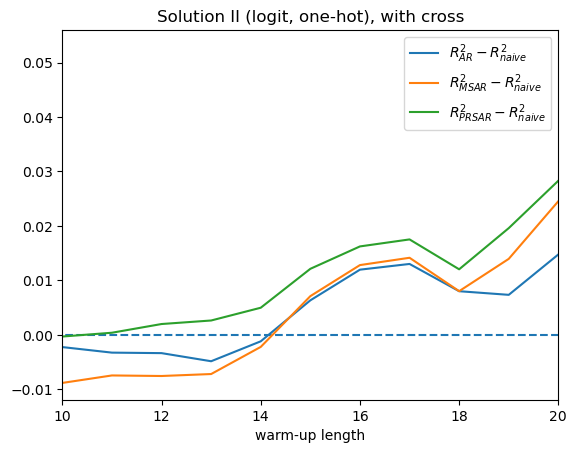

In [136]:
list_x, list_y_ar, list_y_mslr, list_y_mslrx = [], [], [], []
for cc, (tmp_r2_ar, tmp_r2_naive, tmp_rocauc_ar, tmp_rocauc_naive, tmp_r2_mslrx, tmp_r2_naive, tmp_rocauc_mslrx, tmp_rocauc_naive, tmp_r2_mslr, tmp_r2_naive, tmp_rocauc_mslr, tmp_rocauc_naive) in enumerate(list_res_logitonehot_cross):
    len_warmup = cc + 7
    list_x.append(len_warmup)
    list_y_ar.append(tmp_r2_ar - tmp_r2_naive)
    list_y_mslr.append(tmp_r2_mslr - tmp_r2_naive)
    list_y_mslrx.append(tmp_r2_mslrx - tmp_r2_naive)
    
plt.hlines(0.0, 0, 100, linestyles = "--")
plt.plot(list_x, list_y_ar, label = r'$R^2_{AR} - R^2_{naive}$')
plt.plot(list_x, list_y_mslr, label = r'$R^2_{MSAR} - R^2_{naive}$')
plt.plot(list_x, list_y_mslrx, label = r'$R^2_{PRSAR} - R^2_{naive}$')
plt.legend()
plt.xlim(10, 20)
plt.xlabel("warm-up length")
plt.title("Solution II (logit, one-hot), with cross")
plt.show()


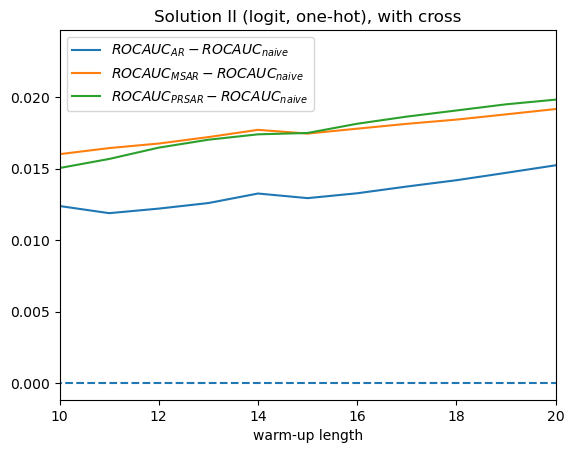

In [145]:

list_x, list_y_ar, list_y_mslr, list_y_mslrx = [], [], [], []
for cc, (tmp_r2_ar, tmp_r2_naive, tmp_rocauc_ar, tmp_rocauc_naive, tmp_r2_mslrx, tmp_r2_naive, tmp_rocauc_mslrx, tmp_rocauc_naive, tmp_r2_mslr, tmp_r2_naive, tmp_rocauc_mslr, tmp_rocauc_naive) in enumerate(list_res_logitonehot_cross):
    len_warmup = cc + 7
    list_x.append(len_warmup)
    list_y_ar.append(tmp_rocauc_ar - tmp_rocauc_naive)
    list_y_mslr.append(tmp_rocauc_mslr - tmp_rocauc_naive)
    list_y_mslrx.append(tmp_rocauc_mslrx - tmp_rocauc_naive)
    
plt.hlines(0.0, 0, 100, linestyles = "--")
plt.plot(list_x, list_y_ar, label = r'$ROCAUC_{AR} - ROCAUC_{naive}$')
plt.plot(list_x, list_y_mslr, label = r'$ROCAUC_{MSAR} - ROCAUC_{naive}$')
plt.plot(list_x, list_y_mslrx, label = r'$ROCAUC_{PRSAR} - ROCAUC_{naive}$')
plt.legend()
plt.xlim(10, 20)
plt.xlabel("warm-up length")
plt.title("Solution II (logit, one-hot), with cross")
plt.show()
    

## Solution III

In [35]:
class MSLRXSoluIII():
    
    def __init__(self, n_components = 2, covariance_type="full", n_iter = 10, tol_loglik = 0.):
        
        self.n_components = n_components
        self.covariance_type = covariance_type 
        self.n_iter = n_iter
        self.min_iter = 3
        self.tol_loglik = tol_loglik
        self.is_print_loglik = False
        
        self.reg_method = LinearRegression
        #self.reg_method = RidgeCV
        #self.reg_method = LinearSVR
            
        return
    
    
    def _est_trans_mat(self, list_exog):
        
        list_list_trans_mat = []
        for exog in list_exog:
            T, K = len(exog), self.n_components
            list_trans_mat = []
            for tmp_exog in exog:
                tmp_trans_mat = []
                for ii in range(K):
                    tmp_prob_1 = tmp_exog @ self.list_coef_[ii] + self.list_intercept_[ii]
                    tmp_prob_1 = max(min(tmp_prob_1, 1 - 1e-5), 1e-5)
                    tmp_prob_0 = 1 - tmp_prob_1
                    tmp_trans_mat.append([tmp_prob_0, tmp_prob_1])
                list_trans_mat.append(np.array(tmp_trans_mat))
            list_list_trans_mat.append(np.array(list_trans_mat))
            
        return list_list_trans_mat
    
    
    def _update_coef(self, list_array3d_log_epsilon, list_exog):
        
        K = self.n_components
        self.list_coef_, self.list_intercept_ = [], []
        for ii in range(K):
            
            tmp_X, tmp_y, tmp_weight = [], [], []
            tmp_X_nan, tmp_y_nan, tmp_weight_nan = [], [], []
            for array3d_log_epsilon, exog in zip(list_array3d_log_epsilon, list_exog):
                T = len(array3d_log_epsilon)
                for tt in range(T):
                    for jj in range(K):
                        tmp_weight_cell = np.exp(array3d_log_epsilon[tt, ii, jj])
                        if np.isnan(tmp_weight_cell) or np.isinf(tmp_weight_cell):
                            tmp_X_nan.append(exog[tt])
                            tmp_y_nan.append(jj)
                            tmp_weight_nan.append(tmp_weight_cell)
                        else:
                            tmp_X.append(exog[tt])
                            tmp_y.append(jj)
                            tmp_weight.append(tmp_weight_cell)

            if len(tmp_y_nan) >= 1: 
                print("Warning: encountering % s nan in weight in ghmm_exog._update_coef" % len(tmp_y_nan))
                if len(set(tmp_y)) < K:
                    tmp_X, tmp_y, tmp_weight = np.array(tmp_X_nan), np.array(tmp_y_nan), np.array(tmp_weight_nan)
                    tmp_weight = 1
            
            tmp_X = sm.add_constant(tmp_X, has_constant='add', prepend=True)
            res_glm = sm.GLM(exog = tmp_X, endog = tmp_y, family=sm.families.Binomial(link = sm.families.links.identity()), freq_weights = tmp_weight).fit()
            
            tmp_intercept = res_glm.params[0]
            tmp_coef = np.array(res_glm.params[1:])
            
            self.list_coef_.append(tmp_coef) 
            self.list_intercept_.append(tmp_intercept)

        return
    
    
    def fit_predict(self, X, Y, exog, X_test, is_multiple_sequence = False):
        
        matmul_log = lambda A, log_b: np.array([logsumexp(np.log(tmp_line) + log_b) for tmp_line in A])
        
        self.is_fitted = True
        self.is_initialized = False
        
        if is_multiple_sequence:
            list_X, list_Y = [np.array(i) for i in X], [np.array(i) for i in Y]
            list_X_test = [np.array(i) for i in X_test] if X_test is not None else None
            list_exog = [np.array(i) for i in exog]
        else:
            list_X, list_Y = [np.array(X)], [np.array(Y)]
            list_X_test = [np.array(X_test)] if X_test is not None else None
            list_exog = [np.array(exog)]
        
        n_seq = len(list_Y)
        list_T = [len(i) for i in list_Y]
        
        p_X, p = len(list_X[0][0]), len(list_Y[0][0])
        p_exog = len(list_exog[0][0])
        K = self.n_components
        self.n_features = p
        
        marginal_X, marginal_Y = np.concatenate(list_X), np.concatenate(list_Y)
        gmm = GaussianMixture(n_components = self.n_components, covariance_type = self.covariance_type)
        gmm.fit(marginal_Y)
        
        self.list_coef_ = [np.zeros(shape = p_exog) for i in range(K)]
        self.list_intercept_ = [1 / K for i in range(K)]
        list_cur_list_trans_mat = self._est_trans_mat(list_exog)

        self.list_loglik_ = []
        for epoch in range(self.n_iter):

            # M-step
            if epoch != 0:
                tmp_weight_mat = []
                for cur_log_forward_prob, cur_log_backward_prob in zip(list_cur_log_forward_prob, list_cur_log_backward_prob):
                    tmp_log_weight_mat = cur_log_forward_prob + cur_log_backward_prob
                    tmp_log_weight_mat -= logsumexp(tmp_log_weight_mat[-1, :])
                    tmp_weight_mat.append(np.exp(tmp_log_weight_mat))
                tmp_weight_mat = np.concatenate(tmp_weight_mat)
            else:
                tmp_weight_mat = gmm.predict_proba(marginal_Y)
                
            list_lr_cov = []
            for ii in range(K):
                tmp_weight = tmp_weight_mat[:, ii]
                tmp_lr = self.reg_method()
                tmp_lr.fit(marginal_X, marginal_Y, sample_weight = tmp_weight)
                tmp_resid = marginal_Y - tmp_lr.predict(marginal_X)
                if self.covariance_type == "full":
                    tmp_cov_sum = np.zeros(shape = (p, p))
                    for jj in range(len(marginal_X)):
                        tmp_x = tmp_resid[jj, :]
                        tmp_cov_sum += np.outer(tmp_x, tmp_x) * tmp_weight[jj]
                    tmp_cov = tmp_cov_sum / np.sum(tmp_weight) 
                elif self.covariance_type == "diag":
                    tmp_cov = np.array([max(np.sum(tmp_weight * (tmp_resid[:, j] ** 2)) / np.sum(tmp_weight), 1e-12) for j in range(p)])
                list_lr_cov.append((tmp_lr, tmp_cov))
            self.list_lr_cov = list_lr_cov
            
            list_cur_mat_log_b = self._calc_emission_mat(list_X, list_Y)
                        
            if epoch != 0:
                cur_log_initprob = [list_cur_log_forward_prob[i][0] + list_cur_log_backward_prob[i][0] for i in range(n_seq)]
            else:
                cur_log_initprob = [[np.log(i) if i != 0 else -100 for i in line] for line in gmm.predict_proba([Y[0] for Y in list_Y])]
            
            cur_log_initprob = np.sum(cur_log_initprob, axis = 0)
            cur_log_initprob -= logsumexp(cur_log_initprob)
            self.startprob_ = np.exp(cur_log_initprob)
            self.log_startprob_ = cur_log_initprob

            # E-step      
            list_cur_log_forward_prob = [[] for i in range(n_seq)]
            for index_X, X in enumerate(list_X):
                for tt in range(len(X)):
                    if tt == 0:
                        tmp_log_prob = cur_log_initprob + list_cur_mat_log_b[index_X][0, :]
                    else:
                        tmp_log_prob = matmul_log(np.transpose(list_cur_list_trans_mat[index_X][tt - 1]), list_cur_log_forward_prob[index_X][-1]) + list_cur_mat_log_b[index_X][tt, :]
                    list_cur_log_forward_prob[index_X].append(tmp_log_prob)
            list_cur_log_forward_prob = [np.array(i) for i in list_cur_log_forward_prob]
            
            list_cur_log_backward_prob = [[0 for i in range(T)] for T in list_T]
            for index_X, (X, T) in enumerate(zip(list_X, list_T)):
                for tt in range(T - 1, -1, -1):
                    if tt == T - 1:
                        tmp_log_prob = np.array([np.log(1.) for i in range(K)])
                    else:
                        tmp_log_prob = []
                        for ii in range(K):
                            tmp_log_prob.append(logsumexp([np.log(list_cur_list_trans_mat[index_X][tt][ii, j]) + list_cur_mat_log_b[index_X][tt + 1, j] + list_cur_log_backward_prob[index_X][tt + 1][j] for j in range(K)]))
                        tmp_log_prob = np.array(tmp_log_prob)
                    list_cur_log_backward_prob[index_X][tt] = tmp_log_prob
            list_cur_log_backward_prob = [np.array(i) for i in list_cur_log_backward_prob]
            
            list_tmp_array2d_log_gamma = [i + j for (i, j) in zip(list_cur_log_forward_prob, list_cur_log_backward_prob)]
            list_tmp_array1d_log_gamma_sum = [[logsumexp(i[t, :]) for t in range(len(i))] for i in list_tmp_array2d_log_gamma]
            
            list_tmp_array3d_log_epsilon = [np.zeros(shape = (T - 1, K, K)) for T in list_T]
            for index_X, (X, T) in enumerate(zip(list_X, list_T)):
                for tt in range(T - 1):
                    for ii in range(K):
                        for jj in range(K):
                            list_tmp_array3d_log_epsilon[index_X][tt, ii, jj] = list_cur_log_forward_prob[index_X][tt, ii] + np.log(list_cur_list_trans_mat[index_X][tt][ii, jj]) + \
                                    list_cur_log_backward_prob[index_X][tt + 1, jj] + list_cur_mat_log_b[index_X][tt + 1, jj] - list_tmp_array1d_log_gamma_sum[index_X][tt]            
        
            self._update_coef(list_tmp_array3d_log_epsilon, list_exog) # update coef and intercept for transmat
            list_cur_list_trans_mat = self._est_trans_mat(list_exog)
            self.list_cur_list_trans_mat = list_cur_list_trans_mat
            
            loglik = np.sum([logsumexp(i[-1]) for i in list_cur_log_forward_prob])
            self.list_loglik_.append(loglik)
            
            self.is_initialized = True
            
            if self.is_print_loglik:
                print("epoch % s, loglik = % s" % (epoch, loglik))
            
            if (len(self.list_loglik_) >= 2) and (abs(self.list_loglik_[-1] - self.list_loglik_[-2]) < self.tol_loglik):
                break
        
        self.list_last_posterior = [i[-1] + j[-1] for (i, j) in zip(list_cur_log_backward_prob, list_cur_log_forward_prob)]
        self.list_log_pred_posterior = []
        for ii in range(n_seq):
            tmp = self.list_last_posterior[ii]
            tmp -= logsumexp(tmp)
            self.list_last_posterior[ii] = np.exp(tmp)
            self.list_log_pred_posterior.append(matmul_log(np.transpose(list_cur_list_trans_mat[ii][-1]), tmp))
            
        if list_X_test is None:
            pred = None
        else:
            pred = []
            for ii in range(n_seq):
                tmp_pred_prob = np.exp(self.list_log_pred_posterior[ii])
                tmp_pred = 0
                for tmp_k in range(K):
                    tmp_pred += list_lr_cov[tmp_k][0].predict([list_X_test[ii]])[0] * tmp_pred_prob[tmp_k]
                pred.append(tmp_pred)

            if not is_multiple_sequence:
                pred = pred[0]
        
        return pred
    
    
    def fit(self, X, Y, exog, is_multiple_sequence = False):
        self.fit_predict(X = X, Y = Y, exog = exog, X_test = None, is_multiple_sequence = is_multiple_sequence)
        return
    
    
    def _calc_emission_mat(self, list_X, list_Y):
        
        list_T = [len(i) for i in list_X]
        p, K = self.n_features, self.n_components
        
        list_cur_mat_log_b = [np.zeros(shape = (i, K)) for i in list_T]
        for ii, (tmp_lr, tmp_cov) in enumerate(self.list_lr_cov):
            for index_X, (X, Y) in enumerate(zip(list_X, list_Y)):
                tmp_resid = Y - tmp_lr.predict(X)
                if self.covariance_type == "full":
                    list_cur_mat_log_b[index_X][:, ii] = scipy.stats.multivariate_normal.logpdf(tmp_resid, mean=[0] * p, cov=tmp_cov)
                elif self.covariance_type == "diag":
                    tmp_logprob = 0
                    for jj in range(p):
                        tmp_logprob += scipy.stats.norm.logpdf(tmp_resid[:, jj], loc = 0, scale = np.sqrt(tmp_cov[jj]))
                    list_cur_mat_log_b[index_X][:, ii] = tmp_logprob

        return list_cur_mat_log_b
    
    
    def online_predict(self, X_test, Y_test, exog_test, is_multiple_sequence = False):
        
        if not self.is_fitted:
            print("Error: Not fitted. MSLRX's online_predict method must be used AFTER fit")
            return
            
        matmul_log = lambda A, log_b: np.array([logsumexp(np.log(tmp_line) + log_b) for tmp_line in A])
        
        if is_multiple_sequence:
            list_X_test, list_Y_test = [np.array(i) for i in X_test], [np.array(i) for i in Y_test]  
            list_exog_test = [np.array(i) for i in exog_test] 
        else:
            list_X_test, list_Y_test = [np.array(X_test)], [np.array(Y_test)] 
            list_exog_test = [np.array(exog_test)] 

        list_T = [len(i) for i in list_Y_test]
        K = self.n_components
        
        list_cur_mat_log_b = self._calc_emission_mat(list_X_test, list_Y_test)
        list_cur_list_trans_mat = self._est_trans_mat(list_exog_test)

        list_pred = []
        for ii, (cur_mat_log_b, cur_list_trans_mat) in enumerate(zip(list_cur_mat_log_b, list_cur_list_trans_mat)):
            pred = []
            log_last_posterior = self.list_log_pred_posterior[ii]
            for tt in range(list_T[ii]):
                
                log_last_posterior = log_last_posterior + cur_mat_log_b[tt, :]         
                log_last_posterior = matmul_log(np.transpose(cur_list_trans_mat[tt]), log_last_posterior)                    
                log_last_posterior -= logsumexp(log_last_posterior)
                tmp_posterior = np.exp(log_last_posterior)
                
                if tt + 1 < len(list_X_test[ii]):
                    tmp_mean_pred = 0
                    for tmp_k in range(K):
                        tmp_mean_pred += self.list_lr_cov[tmp_k][0].predict([list_X_test[ii][tt + 1]])[0] * tmp_posterior[tmp_k]
                    pred.append(tmp_mean_pred)
                
            self.list_log_pred_posterior[ii] = log_last_posterior
            pred = np.array(pred)
            list_pred.append(pred)
            
        if not is_multiple_sequence:
            list_pred = list_pred[0]
        list_pred = np.array(list_pred)

        res = list_pred
            
        return res
    
    
def _test_MSLRXSoluIII():
    
    start_time = datetime.datetime.now()
    print("start running _test_MSLRXSoluIII()")
    
    list_beta = [np.array([[0.5, 0.5], [0.5, 0.5], [0.5, 0.5]]), 
                 np.array([[-0.5, 0.7], [-0.5, -0.8], [-0.5, -0.2]]),]
    list_intercept = [np.array([1., 2.]), np.array([8., 2.])]
    list_cov = [np.array([[1., 0.1], [0.1, 1.]]), np.array([[3., 0.1], [0.1, 3.]])]
    transmat = np.array([[0.9, 0.1], [ 0.3, 0.7]])
    init_prob = np.array([1 / 3, 2 / 3])
    n_components = len(list_beta)
    K = n_components
    p_X = len(list_beta[0])
    p_exog = 5
    
    list_coef_transmat = [np.random.uniform(size = (p_exog, K), low = -1., high = 1.) for i in range(K)]
    list_intercept_transmat = [np.random.uniform(size = K) for i in range(K)]
    for line in list_coef_transmat:
        line[0, :] = 0
    
    T_train = 1000
    T_test = 50
    T = T_train + T_test
    
    list_X, list_Y, list_exog = [], [], []
    for ii in range(100):
        
        X = np.random.normal(loc=1.0, scale=5.0, size=(T, p_X))
        exog = np.random.normal(loc=0.0, scale=1.0, size = (T, p_exog))
        Y, list_h_label = [], []
        for tt in range(T):
            
            index = tt
            
            if index != 0:
                trans_mat = []
                for ii in range(K):
                    tmp_log_prob = exog[index - 1] @ list_coef_transmat[ii] + list_intercept_transmat[ii]
                    tmp_log_prob -= np.max(tmp_log_prob)
                    tmp_prob = np.exp(tmp_log_prob)
                    tmp_prob /= np.sum(tmp_prob)
                    trans_mat.append(tmp_prob)
                trans_mat = np.array(trans_mat)
                prob_h_tmp = (h_label_prev @ trans_mat)[0]
            else:
                prob_h_tmp = init_prob
            
            h_label_tmp_vec = np.random.multinomial(n = 1, pvals = prob_h_tmp, size = 1)
            h_label_tmp = np.argmax(h_label_tmp_vec)
            tmp_h_label = h_label_tmp
            h_label_prev = h_label_tmp_vec
            
            list_h_label.append(tmp_h_label)
            
            tmp_Y = X[tt, :] @ list_beta[tmp_h_label] + list_intercept[tmp_h_label] + np.random.multivariate_normal(mean = [0, 0], cov = list_cov[tmp_h_label])
            Y.append(tmp_Y)
            
        Y = np.array(Y)
        
        list_X.append(X)
        list_Y.append(Y)
        list_exog.append(exog)
        
    print("data prepared", str(datetime.datetime.now() - start_time))
        
    mslrx = MSLRXSoluIII(n_components=2, covariance_type="full", n_iter=10)
    pred = mslrx.fit_predict(X = [X[:T_train] for X in list_X],
                             Y = [Y[:T_train] for Y in list_Y],
                             exog = [exog[:T_train] for exog in list_exog],
                             X_test = [X[T_train, :] for X in list_X], 
                             is_multiple_sequence=True)
    ol_pred = mslrx.online_predict(X_test = [X[T_train:] for X in list_X],
                                   Y_test = [Y[T_train:] for Y in list_Y], 
                                   exog_test = [exog[T_train:] for exog in list_exog],
                                   is_multiple_sequence = True)
    
    list_pred = [[] for i in range(len(list_X))]
    for cc, (tmp_pred, tmp_pred_ol) in enumerate(zip(pred, ol_pred)):
        list_pred[cc].append(tmp_pred)
        list_pred[cc].extend(tmp_pred_ol)

    print("r2 =", r2_score(y_true = np.array([Y[T_train] for Y in list_Y]).flatten(), y_pred=np.array(pred).flatten()))
    print("r2 =", r2_score(y_true = np.array([Y[T_train:] for Y in list_Y]).flatten(), y_pred=np.array(list_pred).flatten()))
    print("running time =", str(datetime.datetime.now() - start_time))
    
    return


_test_MSLRXSoluIII()


start running _test_MSLRXSoluIII()
data prepared 0:00:23.829001
r2 = 0.445310224426932
r2 = 0.46450421521244634
running time = 0:07:18.824684


## End of notebook

### Back up

In [4]:
df_ooi = pd.read_csv("data/ooi-gi01sumo-sbd12-02-flortd000_655e_fffa_3b24.csv", skiprows=1, parse_dates=["UTC"])
df_ooi = df_ooi.rename(columns = {"UTC": "time", "m": "z", "microg.L-1": "mass_concentration_of_chlorophyll_a_in_sea_water", "m-1": "flubsct", })
del df_ooi["z"]
df_ooi = df_ooi.set_index("time")

In [5]:
array_cross = df_ooi["flubsct"].resample("1h").mean().to_numpy()
array_obs = df_ooi["mass_concentration_of_chlorophyll_a_in_sea_water"].resample("1h").mean().to_numpy()
array_datetime = df_ooi["mass_concentration_of_chlorophyll_a_in_sea_water"].resample("1h").mean().index.to_numpy()

# flubsct: https://oceanobservatories.org/data-product/flubsct/

In [6]:
list_split_index = list(np.where(np.isnan(array_obs))[0])
list_split_index.append(len(array_obs))
list_split_index.insert(0, 0)
list_subseq = []
list_subseq_cross = []
list_subseq_datetime = []
for tmp_index in range(len(list_split_index) - 1):
    tmp_index_left = list_split_index[tmp_index] + 1
    tmp_index_right = list_split_index[tmp_index + 1]
    if tmp_index_right - tmp_index_left < 24 * 20:
        continue
    list_subseq.append(array_obs[tmp_index_left:tmp_index_right])
    list_subseq_datetime.append(array_datetime[tmp_index_left:tmp_index_right])
    list_subseq_cross.append(array_cross[tmp_index_left:tmp_index_right])
    

In [6]:
list_p_AR = [1, 2, 3, 24]
list_p_AR_cross = [1, 2, 3, 4, 5, 6]
max_p = max(max(list_p_AR), max(list_p_AR_cross))

list_X, list_Y = [], []
for tmp_subseq, tmp_subseq_cross, tmp_subseq_datetime in zip(list_subseq, list_subseq_cross, list_subseq_datetime):
    X, Y = [], []
    for tmp_index_test in range(max(max_p, 24), len(tmp_subseq) - 24):
        tmp_X = []
        for tmp_p in list_p_AR:
            tmp_X.append(tmp_subseq[tmp_index_test - tmp_p])
        for tmp_p in list_p_AR_cross:
            tmp_X.append(tmp_subseq_cross[tmp_index_test - tmp_p])
        X.append(tmp_X)
        #Y.append([np.max(tmp_subseq[tmp_index_test:(tmp_index_test + 24)])])
        Y.append([tmp_subseq[tmp_index_test]])
    list_X.append(X)
    list_Y.append(Y)


In [7]:
mslr = MSLR(n_components=2, covariance_type="full", n_iter=30)
mslr.fit(list_X, list_Y, is_multiple_sequence=True)

In [8]:
mslr.transmat_

array([[0.92969346, 0.07030654],
       [0.11152324, 0.88847676]])

In [29]:
mslr.list_lr_cov[0][0].coef_

array([[ 1.30808937, -0.35644588,  0.02251881,  0.0184774 , -5.4634466 ,
         3.83674627,  0.50196788,  0.47420418,  0.49292417, -0.21874912]])

In [30]:
mslr.list_lr_cov[1][0].coef_

array([[ 1.28949429, -0.33371928, -0.07205749,  0.08318836, -7.75686432,
         4.21328408, 11.46394785,  4.37048813, -4.96238271, -4.44986662]])

In [31]:
mslr.list_lr_cov[0][1], mslr.list_lr_cov[1][1]

(array([[0.00028438]]), array([[0.05643479]]))